In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso
from sklearn.metrics import roc_auc_score, auc, roc_curve
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report
from test_function import *
import random
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from test_function import *
from sklearn.ensemble import GradientBoostingClassifier
from scipy import stats

import statsmodels.stats.proportion as proportion

In [34]:
x_column = ['SIFT_pred','LRT_pred', 'MA_pred', 'PROVEAN_pred', 'SLR_score', 'SIFT_score','LRT_omega', 
                'MA_score', 'PROVEAN_score', 'Grantham', 'HMMEntropy','HMMRelEntropy', 'PredRSAB', 'PredRSAI', 
                'PredRSAE','PredBFactorF', 'PredBFactorM', 'PredBFactorS', 'PredStabilityH','PredStabilityM', 
                'PredStabilityL', 'PredSSE', 'PredSSH','PredSSC', 'dscore', 'phyloP_pri', 'phyloP_mam','phyloP_ver','RNA_seq','UNEECON']
y_column = 'clinvar_result'



In [3]:
# processing data
# balanced omit
omit = pd.read_csv("unannotated_omit_std.tsv", sep = "\t")
dominant = pd.read_csv('dominant_std.tsv', sep = "\t")
recessive = pd.read_csv('recessive_std.tsv', sep = "\t")

In [4]:
# creating training set, validation set, testing set
def split(df, Xname, Yname, testsize = 0.1):
    y = df.loc[:,[Yname]].values
    y = y.flatten()
    X = df.loc[:,Xname]
    Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size = testsize, random_state = 42)
    
    
    
    Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size = testsize, random_state = 42)    
    Xtrain, Xvalid, ytrain, yvalid =  train_test_split(Xtrain,ytrain, test_size = 0.11, random_state = 42)
    
    return(Xtrain, Xvalid, Xtest, ytrain, yvalid, ytest)


X_train, X_valid, X_test, y_train, y_valid, y_test = split(omit, x_column, y_column)
X_train_domi, X_valid_domi, X_test_domi, y_train_domi, y_valid_domi, y_test_domi = split(dominant, x_column, y_column)
X_train_recess, X_valid_recess, X_test_recess, y_train_recess, y_valid_recess, y_test_recess = split(recessive, x_column, y_column)
   

In [5]:
#add new column to original df
def merge(df1, df2, column):
    df3 = df1.copy()
    df3[column] = df2.tolist()
    return(df3)

In [6]:
train3 = merge(X_train, y_train, 'clinvar_result')
train3_domi = merge(X_train_domi, y_train_domi, 'clinvar_result')
train3_recess = merge(X_train_recess, y_train_recess, 'clinvar_result')

valid = merge(X_valid, y_valid, 'clinvar_result')
valid_domi = merge(X_valid_domi, y_valid_domi, 'clinvar_result')
valid_recess = merge(X_valid_recess, y_valid_recess, 'clinvar_result')

In [8]:
## skip this part when rerun 

train3.to_csv('/storage/home/jkl5991/work/project/not_conflict/cv/0730/original/train.tsv', sep = '\t',index = False)
train3_domi.to_csv('/storage/home/jkl5991/work/project/not_conflict/cv/0730/original/train_domi.tsv', sep = '\t',index = False)
train3_recess.to_csv('/storage/home/jkl5991/work/project/not_conflict/cv/0730/original/train_recess.tsv', sep = '\t',index = False)


valid.to_csv('/storage/home/jkl5991/work/project/not_conflict/cv/0730/original/valid.tsv', sep = '\t',index = False)
valid_domi.to_csv('/storage/home/jkl5991/work/project/not_conflict/cv/0730/original/valid_domi.tsv', sep = '\t',index = False)
valid_recess.to_csv('/storage/home/jkl5991/work/project/not_conflict/cv/0730/original/valid_recess.tsv', sep = '\t',index = False)

In [21]:
def drawROC(ytest, ytest_hat, lw=3, linestyle = '--', label = '', lastone = False, MoreThanOnelocation = 'lower right', fontsize = 12, title = '', legendloc = False):
    fpr, tpr, thresholds = roc_curve(ytest, ytest_hat)
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr, tpr, lw = lw, linestyle = linestyle, label = label + ', (AUC = %0.3f)'%roc_auc)
    if lastone == True:
        if legendloc != False:
            ax.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=lengend,borderaxespad=0, frameon=False)
        else:
            plt.legend(loc = 'lower right', fontsize = 12)
        plt.title(title)
        
        fig = plt.figure()
        return(fig)

    
def get_ROC(ax,ytest, ytest_hat, label, lastone = False, x = 'False Positive Rate', y = 'True Positive Rate', title = None, legendloc = 'lower right', lw = 2, linestyle = '-'):
    fpr, tpr, thresholds = roc_curve(ytest, ytest_hat)
    auroc = auc(fpr,tpr)
    ax.plot(fpr, tpr, lw = lw, linestyle = linestyle, label = label +', (auROC=%0.3f)'%auroc)
    if(lastone == True):
        ax.set_xlabel(x,fontsize = 22)
        ax.set_ylabel(y, fontsize = 22)
        ax.set_title(title, fontsize = 22)
        ax.legend(loc='lower right',fontsize = 22)

/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

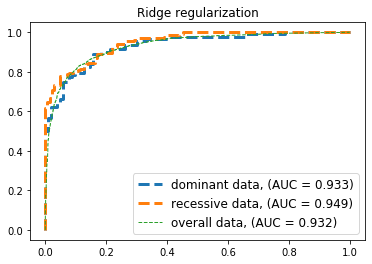

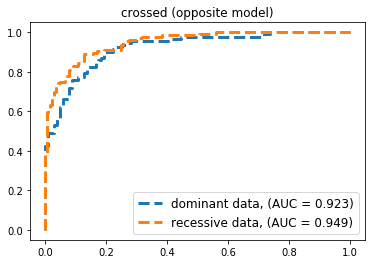

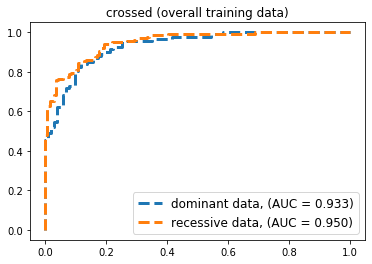

<Figure size 432x288 with 0 Axes>

In [22]:
#logistic regression
def logistic(Xtrain, ytrain, Xtest, ytest, fitmodel = False):    
    if(fitmodel != False):
        model = fitmodel
        
    else:
        model = LogisticRegression(random_state = 42 , penalty = 'l2').fit(Xtrain, ytrain)
        
    test_hat = model.predict_proba(Xtest)[:,1]
    return(ytest,test_hat, model)


domi_l2 = logistic(X_train_domi, y_train_domi, X_test_domi, y_test_domi)
recess_l2 = logistic(X_train_recess, y_train_recess, X_test_recess, y_test_recess)
omit_l2 = logistic(X_train, y_train, X_test, y_test)
plt.rcParams['figure.figsize'] = [6,4]


drawROC(domi_l2[0], domi_l2[1],label = 'dominant data')
drawROC(recess_l2[0],recess_l2[1], label = "recessive data")
drawROC(omit_l2[0],omit_l2[1], lw =1,label = "overall data",lastone = True, title = "Ridge regularization")

# ridge cross
domi_l2_cross = logistic(0, 0, X_test_domi, y_test_domi, fitmodel = recess_l2[2])
recess_l2_cross = logistic(0,0, X_test_recess, y_test_recess, fitmodel = domi_l2[2])


drawROC(domi_l2_cross[0], domi_l2_cross[1],label = 'dominant data')
drawROC(recess_l2_cross[0],recess_l2_cross[1], label = "recessive data", lastone = True, title = "crossed (opposite model)")



# overall crossed
domi_l2_overall = logistic(0,0,X_test_domi, y_test_domi, fitmodel = omit_l2[2])
recess_l2_overall = logistic(0,0,X_test_recess, y_test_recess, fitmodel = omit_l2[2])



drawROC(domi_l2_overall[0], domi_l2_overall[1],label = 'dominant data')
drawROC(recess_l2_overall[0],recess_l2_overall[1], label = "recessive data", lastone = True, title = "crossed (overall training data)")



In [35]:
# processing data
# balanced omit
omit = pd.read_csv("unannotated_omit_std.tsv", sep = "\t")
dominant = pd.read_csv('dominant_std.tsv', sep = "\t")
recessive = pd.read_csv('recessive_std.tsv', sep = "\t")

In [36]:
coef_domi = domi_l2[2].coef_.flatten()
coef_recess = recess_l2[2].coef_.flatten()
coef_overall = omit_l2[2].coef_.flatten()

cor_reg = pd.DataFrame({'domi_ridge':coef_domi, 'recess_ridge': coef_recess, 'overall': coef_overall}, index = x_column)
print(cor_reg)


                domi_ridge  recess_ridge   overall
SIFT_pred        -0.103582      0.219523  0.653349
LRT_pred          0.534392      0.444339  0.476416
MA_pred           0.212353      0.067671 -0.017159
PROVEAN_pred      0.899138      0.240607  0.397403
SLR_score        -0.248228      0.004266 -0.056289
SIFT_score       -0.073085     -0.146165  0.104149
LRT_omega        -0.111733     -0.281798  0.001018
MA_score          0.317031      0.209090  0.446644
PROVEAN_score     0.235627     -0.696776 -0.334095
Grantham          0.329480     -0.065062  0.004424
HMMEntropy        0.531987      0.126446 -0.285760
HMMRelEntropy    -0.301048      0.053138  0.404657
PredRSAB         -0.006284      0.020531 -0.011912
PredRSAI          0.210761      0.066158  0.008465
PredRSAE         -0.067893      0.015529  0.005388
PredBFactorF      0.284134      0.203819 -0.026375
PredBFactorM      0.088672     -0.011707 -0.129079
PredBFactorS      0.262424      0.097404 -0.050239
PredStabilityH   -0.258981     

In [39]:
print(cor_reg)

                domi_ridge  recess_ridge   overall
SIFT_pred        -0.103582      0.219523  0.653349
LRT_pred          0.534392      0.444339  0.476416
MA_pred           0.212353      0.067671 -0.017159
PROVEAN_pred      0.899138      0.240607  0.397403
SLR_score        -0.248228      0.004266 -0.056289
SIFT_score       -0.073085     -0.146165  0.104149
LRT_omega        -0.111733     -0.281798  0.001018
MA_score          0.317031      0.209090  0.446644
PROVEAN_score     0.235627     -0.696776 -0.334095
Grantham          0.329480     -0.065062  0.004424
HMMEntropy        0.531987      0.126446 -0.285760
HMMRelEntropy    -0.301048      0.053138  0.404657
PredRSAB         -0.006284      0.020531 -0.011912
PredRSAI          0.210761      0.066158  0.008465
PredRSAE         -0.067893      0.015529  0.005388
PredBFactorF      0.284134      0.203819 -0.026375
PredBFactorM      0.088672     -0.011707 -0.129079
PredBFactorS      0.262424      0.097404 -0.050239
PredStabilityH   -0.258981     

In [41]:
coef_domi = domi_l2[2].coef_.flatten()
coef_recess = recess_l2[2].coef_.flatten()
coef_overall = omit_l2[2].coef_.flatten()

cor_reg = pd.DataFrame({'domi_ridge':coef_domi, 'recess_ridge': coef_recess, 'overall': coef_overall}, index = x_column)
print(cor_reg)


                domi_ridge  recess_ridge   overall
SIFT_pred        -0.103582      0.219523  0.653349
LRT_pred          0.534392      0.444339  0.476416
MA_pred           0.212353      0.067671 -0.017159
PROVEAN_pred      0.899138      0.240607  0.397403
SLR_score        -0.248228      0.004266 -0.056289
SIFT_score       -0.073085     -0.146165  0.104149
LRT_omega        -0.111733     -0.281798  0.001018
MA_score          0.317031      0.209090  0.446644
PROVEAN_score     0.235627     -0.696776 -0.334095
Grantham          0.329480     -0.065062  0.004424
HMMEntropy        0.531987      0.126446 -0.285760
HMMRelEntropy    -0.301048      0.053138  0.404657
PredRSAB         -0.006284      0.020531 -0.011912
PredRSAI          0.210761      0.066158  0.008465
PredRSAE         -0.067893      0.015529  0.005388
PredBFactorF      0.284134      0.203819 -0.026375
PredBFactorM      0.088672     -0.011707 -0.129079
PredBFactorS      0.262424      0.097404 -0.050239
PredStabilityH   -0.258981     

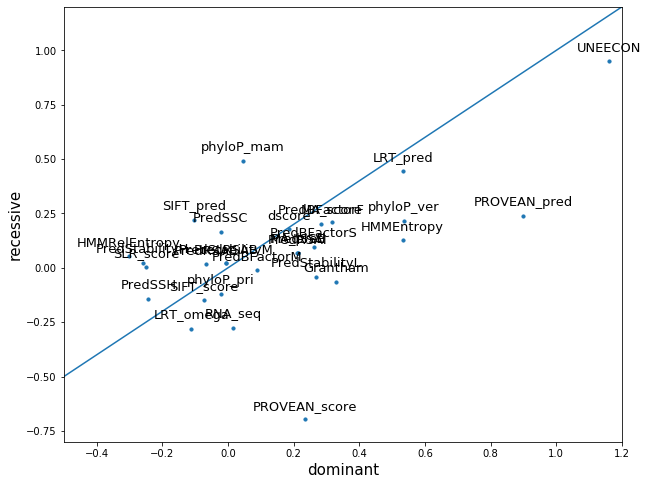

In [42]:
plt.rcParams['figure.figsize'] = [10,8]

a = np.arange(-1,4)
plt.plot(a,a)
plt.scatter(cor_reg['domi_ridge'], cor_reg['recess_ridge'], s = 10)
i = 0
for x,y in zip(cor_reg['domi_ridge'], cor_reg['recess_ridge']):
    label = cor_reg.index[i]
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 size =13)
    i += 1

plt.rcParams['figure.figsize'] = [6,4]
plt.xlim(-0.5,1.2)
plt.ylim(-0.8,1.2)
plt.xlabel('dominant', size = 15)
plt.ylabel('recessive', size = 15)


plt.savefig('figure/4_line_log_coefficient.pdf',bbox_inches='tight')  

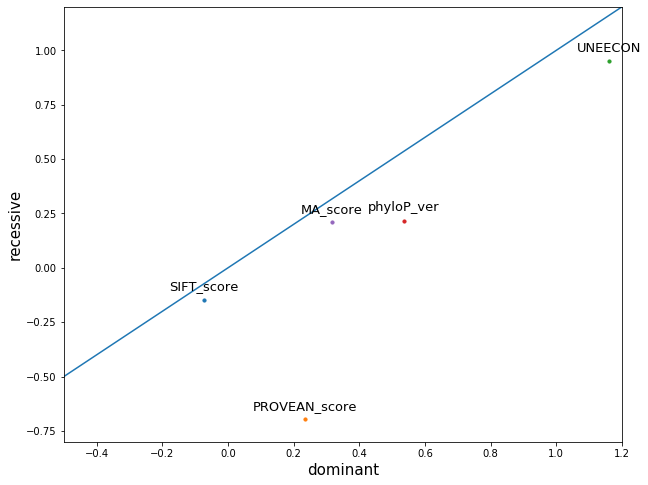

In [75]:
plt.rcParams['figure.figsize'] = [10,8]

a = np.arange(-1,4)
plt.plot(a,a)
label_in_gb = ['SIFT_score', 'PROVEAN_score','UNEECON', 'phyloP_ver', 'MA_score']
i = 0

for i in range(len(label_in_gb)):
    plt.scatter(cor_reg['domi_ridge'][label_in_gb[i]], cor_reg['recess_ridge'][label_in_gb[i]], s = 10)
    label = label_in_gb[i]
    plt.annotate(label, (cor_reg['domi_ridge'][label_in_gb[i]], cor_reg['recess_ridge'][label_in_gb[i]]),
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 size =13)

plt.rcParams['figure.figsize'] = [6,4]
plt.xlim(-0.5,1.2)
plt.ylim(-0.8,1.2)
plt.xlabel('dominant', size = 15)
plt.ylabel('recessive', size = 15)


plt.savefig('figure/4_line_log_coefficient2.pdf',bbox_inches='tight')  

In [52]:
cor_reg['domi_ridge'][label_in_gb[i]], cor_reg['recess_ridge'][label_in_gb[i]]

(-0.07308482343041492, -0.14616458456417294)

In [46]:
cor_reg['domi_ridge']['SIFT_score']

-0.07308482343041492

In [9]:
# SVM
def svm_model(Xtrain, ytrain, Xtest, ytest,C, gamma, bestkernel, model = False):
    if(model != False):
        clf = model
        
    else: 
        print(C, gamma, bestkernel)
        clf = SVC(kernel = bestkernel, C = C, gamma = gamma)
        clf.fit(Xtrain, ytrain)

    test_hat = clf.decision_function(Xtest)
    return(ytest, test_hat, clf)


In [10]:
svm_domi = svm_model( X_train_domi, y_train_domi, X_test_domi, y_test_domi, 10, 0.01, 'rbf')
svm_recess = svm_model(X_train_recess, y_train_recess, X_test_recess, y_test_recess, 10,0.01, 'rbf')
svm_omit = svm_model(X_train, y_train, X_test, y_test,1,0.1, 'rbf')

10 0.01 rbf
10 0.01 rbf
1 0.1 rbf


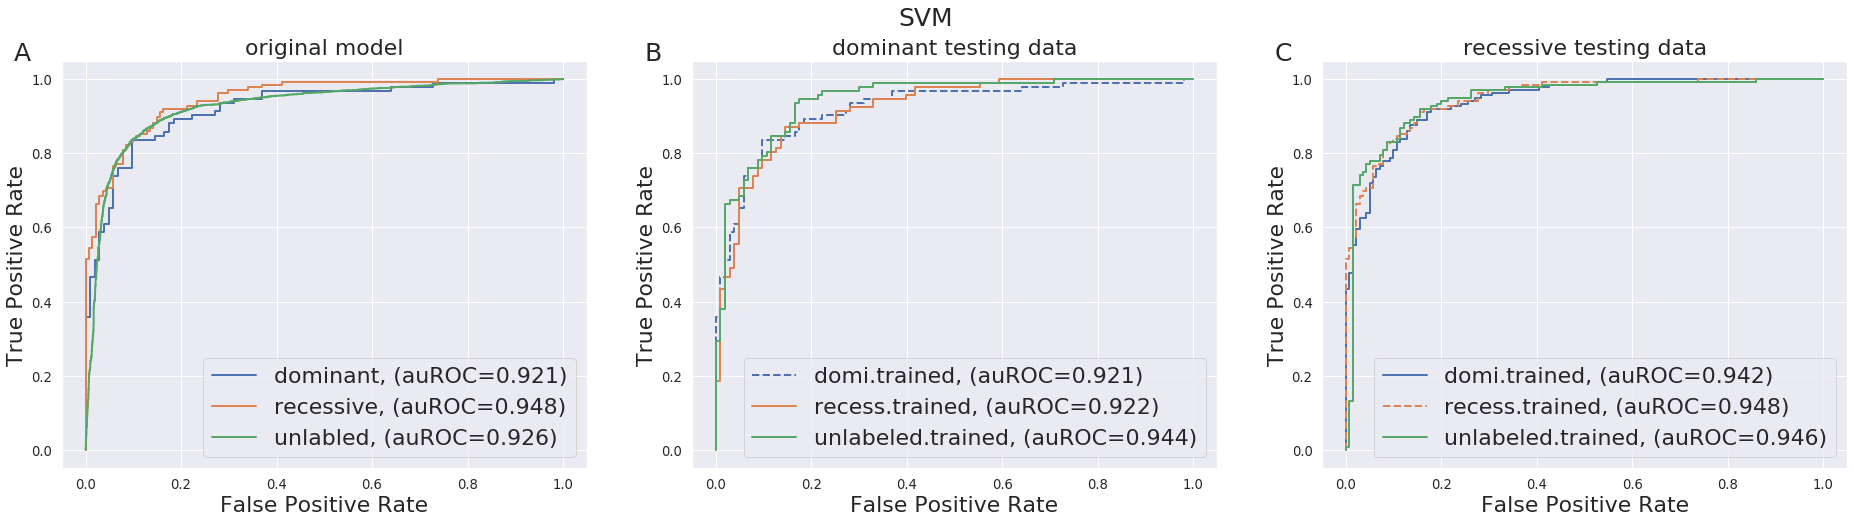

In [474]:

plt.rcParams['figure.figsize'] =[32,7.5]
fig, ax = plt.subplots(1, 3)
fig.suptitle('SVM', size = 25)


#ORIGINAL

get_ROC(ax[0],svm_domi[0],svm_domi[1], label = 'dominant')
get_ROC(ax[0],svm_recess[0],svm_recess[1], label = 'recessive')
get_ROC(ax[0],svm_omit[0],svm_omit[1], lw = 2,label = 'unlabled', lastone = True, title = 'original model')

ax[0].text(-0.15, 1.05, 'A', size = 25)


#DOMINANT

domi_cross = svm_model(0,0,X_test_domi, y_test_domi,0,0,0, model = svm_recess[2])
domi_overall = svm_model(0,0,X_test_domi, y_test_domi, 0,0,0, model = svm_omit[2])

get_ROC(ax[1],svm_domi[0],svm_domi[1], label = 'domi.trained', linestyle = '--')
get_ROC(ax[1], domi_cross[0],domi_cross[1],label = 'recess.trained')
get_ROC(ax[1], domi_overall[0],domi_overall[1],label = 'unlabeled.trained',lastone = True, title = "dominant testing data")
ax[1].text(-0.15, 1.05, 'B', size = 25)



#RECESSIVE
recess_cross = svm_model(0,0,X_test_recess, y_test_recess,0,0,0, model = svm_domi[2])
recess_overall = svm_model(0,0,X_test_recess, y_test_recess, 0,0,0, model = svm_omit[2])

get_ROC(ax[2], recess_cross[0],recess_cross[1], label = "domi.trained")
get_ROC(ax[2],svm_recess[0],svm_recess[1], label = "recess.trained", linestyle = '--')
get_ROC(ax[2], recess_overall[0],recess_overall[1], label = 'unlabeled.trained', lastone = True, title = "recessive testing data")
ax[2].text(-0.15, 1.05, 'C', size = 25)



plt.savefig('figure/4_svm_ROC.pdf',bbox_inches='tight')
plt.show()



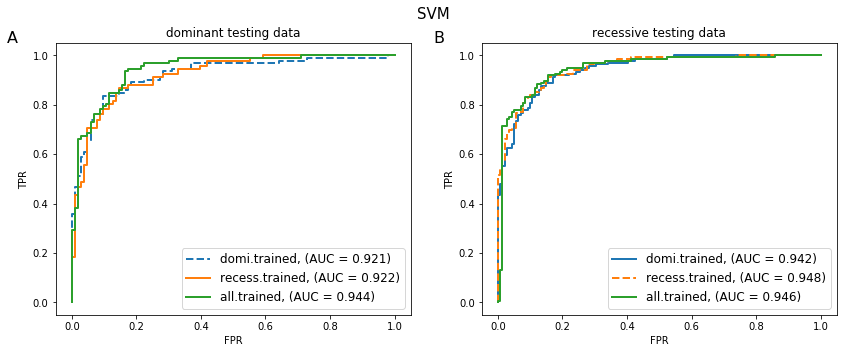

In [219]:
plt.rcParams['figure.figsize'] = [14,5]
fig, ax = plt.subplots(1, 2)
fig.suptitle('SVM', size = 15)


#DOMINANT

domi_cross = svm_model(0,0,X_test_domi, y_test_domi,0,0,0, model = svm_recess[2])
domi_overall = svm_model(0,0,X_test_domi, y_test_domi, 0,0,0, model = svm_omit[2])

get_ROC(ax[0],svm_domi[0],svm_domi[1], label = 'domi.trained', linestyle = '--')
get_ROC(ax[0], domi_cross[0],domi_cross[1],label = 'recess.trained')
get_ROC(ax[0], domi_overall[0],domi_overall[1],label = 'all.trained',lastone = True, title = "dominant testing data")
ax[0].text(-0.2, 1.05, 'A', size = 16)


#RECESSIVE
recess_cross = svm_model(0,0,X_test_recess, y_test_recess,0,0,0, model = svm_domi[2])
recess_overall = svm_model(0,0,X_test_recess, y_test_recess, 0,0,0, model = svm_omit[2])

get_ROC(ax[1], recess_cross[0],recess_cross[1], label = "domi.trained")
get_ROC(ax[1],svm_recess[0],svm_recess[1], label = "recess.trained", linestyle = '--')
get_ROC(ax[1], recess_overall[0],recess_overall[1], label = 'all.trained', lastone = True, title = "recessive testing data")
ax[1].text(-0.2, 1.05, 'B', size = 16)

plt.savefig('figure/4_svm_ROC_onlytwo.pdf')
plt.show()







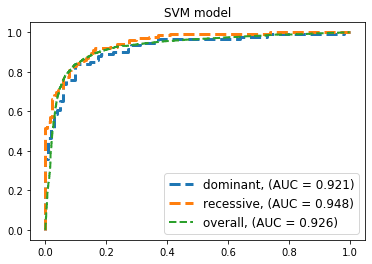

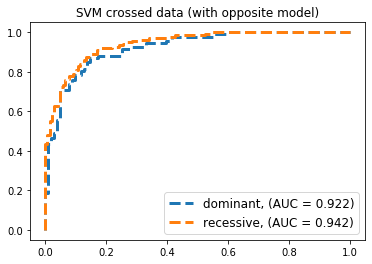

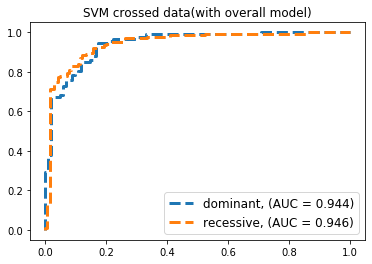

In [18]:
plt.rcParams['figure.figsize'] = [6,4]
drawROC(svm_domi[0],svm_domi[1], label = 'dominant')
drawROC(svm_recess[0],svm_recess[1], label = 'recessive')
drawROC(svm_omit[0],svm_omit[1], lw = 2,label = 'overall', lastone = True, title = 'SVM model')

#cross model(dominant & recessive)
domi_cross = svm_model(0,0,X_test_domi, y_test_domi,0,0,0, model = svm_recess[2])
recess_cross = svm_model(0,0,X_test_recess, y_test_recess,0,0,0, model = svm_domi[2])

drawROC(domi_cross[0], domi_cross[1], label = 'dominant')
drawROC(recess_cross[0], recess_cross[1], label = 'recessive', lastone = True, title = 'SVM crossed data (with opposite model)')

#cross model(with overall data)
domi_overall = svm_model(0,0,X_test_domi, y_test_domi, 0,0,0, model = svm_omit[2])
recess_overall = svm_model(0,0,X_test_recess, y_test_recess, 0,0,0, model = svm_omit[2])

drawROC(domi_overall[0], domi_overall[1], label = 'dominant')
drawROC(recess_overall[0], recess_overall[1], label = 'recessive', lastone = True, title = 'SVM crossed data(with overall model)')

In [118]:
# gradient boosting
tuned_parameters = {"learning_rate" : [0.05,0.1,0.15], 
                   "n_estimators": [100,150,200],
                    "max_depth": [3,5,8]}

In [10]:
#dominant
tuning(X_valid_domi, y_valid_domi, 'gradient boosting', tuned_parameters)

# Tuning hyper-parameters for recall



/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
With score : 0.806

Grid scores on development set:

0.764 (+/-0.064) for {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
0.769 (+/-0.075) for {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 150}
0.775 (+/-0.089) for {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
0.758 (+/-0.054) for {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
0.742 (+/-0.033) for {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 150}
0.748 (+/-0.049) for {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}
0.747 (+/-0.098) for {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 100}
0.753 (+/-0.087) for {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 150}
0.753 (+/-0.087) for {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 200}
0.785 (+/-0.075) for {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
0.780 (+/-0.088) for {

In [11]:
#recessive
tuning(X_valid_recess, y_valid_recess, 'gradient boosting', tuned_parameters)

# Tuning hyper-parameters for recall



/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'learning_rate': 0.15, 'max_depth': 5, 'n_estimators': 200}
With score : 0.873

Grid scores on development set:

0.866 (+/-0.079) for {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
0.869 (+/-0.089) for {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 150}
0.866 (+/-0.079) for {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
0.847 (+/-0.028) for {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
0.844 (+/-0.009) for {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 150}
0.847 (+/-0.018) for {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}
0.829 (+/-0.036) for {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 100}
0.829 (+/-0.051) for {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 150}
0.836 (+/-0.042) for {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 200}
0.859 (+/-0.059) for {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
0.859 (+/-0.059) for 

In [12]:
#overall
tuning(X_valid, y_valid, 'gradient boosting', tuned_parameters)

# Tuning hyper-parameters for recall



/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters set found on development set:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150}
With score : 0.866

Grid scores on development set:

0.863 (+/-0.008) for {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
0.864 (+/-0.006) for {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 150}
0.864 (+/-0.006) for {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
0.863 (+/-0.012) for {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
0.866 (+/-0.010) for {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 150}
0.865 (+/-0.007) for {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}
0.862 (+/-0.009) for {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 100}
0.863 (+/-0.009) for {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 150}
0.862 (+/-0.010) for {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 200}
0.864 (+/-0.008) for {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
0.866 (+/-0.006) for {

In [8]:
def fitting_gb(Xtrain, ytrain, Xtest, ytest, learning, depth, estimator, fitmodel = False):
    if(fitmodel == False):
        model = GradientBoostingClassifier(learning_rate = learning, max_depth = depth, n_estimators = estimator, subsample = 1)
        model.fit(Xtrain, ytrain)
    else:
        model = fitmodel
    
    model_pred = model.decision_function(Xtest)
    
    return(ytest, model_pred, model)

In [9]:
domi_gb = fitting_gb(X_train_domi, y_train_domi, X_test_domi, y_test_domi, 0.1, 3, 150)
recess_gb = fitting_gb( X_train_recess, y_train_recess, X_test_recess, y_test_recess, 0.1, 5, 200)
omit_gb = fitting_gb(X_train, y_train, X_test, y_test, 0.1, 3, 150)

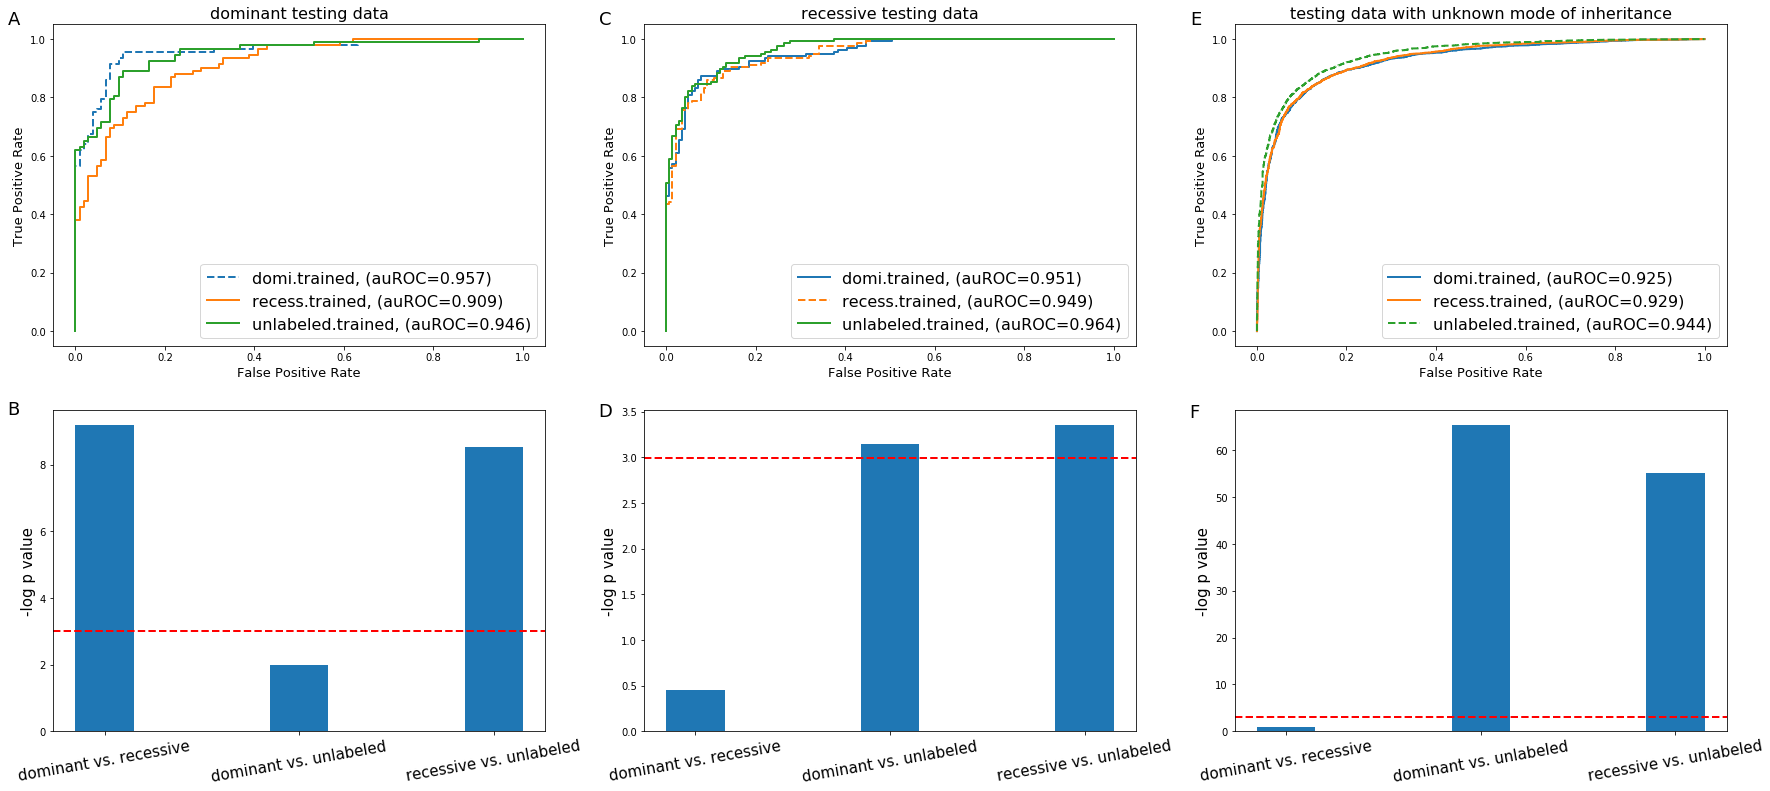

In [10]:
## test
def get_ROC(ax,ytest, ytest_hat, label, lastone = False, x = 'False Positive Rate', y = 'True Positive Rate', title = None, legendloc = 'lower right', lw = 2, linestyle = '-'):
    fpr, tpr, thresholds = roc_curve(ytest, ytest_hat)
    auroc = auc(fpr,tpr)
    ax.plot(fpr, tpr, lw = lw, linestyle = linestyle, label = label +', (auROC=%0.3f)'%auroc)
    if(lastone == True):
        ax.set_xlabel(x,fontsize = 13)
        ax.set_ylabel(y, fontsize = 13)
        ax.set_title(title, fontsize = 16)
        ax.legend(loc='lower right',fontsize = 16)


plt.rcParams['figure.figsize'] = [30,13]
fig, ax = plt.subplots(2,3)

#ORIGINAL
# domi_gb = fitting_gb(X_train_domi, y_train_domi, X_test_domi, y_test_domi, 0.1, 3, 150)
# recess_gb = fitting_gb( X_train_recess, y_train_recess, X_test_recess, y_test_recess, 0.1, 5, 200)
# omit_gb = fitting_gb(X_train, y_train, X_test, y_test, 0.1, 3, 150)



#DOMINANT

domi_cross_gb = fitting_gb(0,0,X_test_domi, y_test_domi,0,0,0, fitmodel = recess_gb[2])
domi_overall_gb = fitting_gb(0,0,X_test_domi, y_test_domi,0,0,0, fitmodel = omit_gb[2])


get_ROC(ax[0,0],domi_gb[0],domi_gb[1], label = 'domi.trained', linestyle = '--')
get_ROC(ax[0,0], domi_gb[0],domi_cross_gb[1],label = 'recess.trained')
get_ROC(ax[0,0], domi_gb[0],domi_overall_gb[1],label = 'unlabeled.trained',lastone = True, title = "dominant testing data")
ax[0,0].text(-0.15, 1.05, 'A', size = 18)


# clust_data = np.array([[1.03e-4], [0.139],[1.97e-4]])
# rowlabel=("dominant vs. recessive", "dominant vs. unlabeled", "recessive vs. unlabeled")
# ax[0,1].axis('off')
# table = ax[0,1].table(cellText = clust_data,rowLabels = rowlabel,loc='center',cellLoc='center',bbox=[0.5,0.4,0.5,0.3])
# table.set_fontsize (16)
# table.scale(1.5, 1.5)

logp=-np.log(0.05)
x_name = ["dominant vs. recessive", "dominant vs. unlabeled", "recessive vs. unlabeled"]
ax[1,0].bar(x_name, -np.log([1.03e-4, 0.139,1.97e-4]), width=0.3, )
ax[1,0].text(-0.5, 9.5, 'B', size = 18)
ax[1,0].set_ylabel('-log p value', size = 15)
ax[1,0].axhline(y=logp, linewidth = 2, color='r', linestyle = '--')
ax[1,0].tick_params(axis='x', labelsize=15, rotation = 10)

#RECESSIVE
recess_cross_gb = fitting_gb(0,0, X_test_recess, y_test_recess ,0,0,0, fitmodel = domi_gb[2])
recess_overall_gb = fitting_gb(0,0,X_test_recess, y_test_recess,0,0,0, fitmodel = omit_gb[2])

get_ROC(ax[0,1], recess_gb[0],recess_cross_gb[1], label = "domi.trained")
get_ROC(ax[0,1],recess_gb[0],recess_gb[1], label = "recess.trained", linestyle = '--')
get_ROC(ax[0,1], recess_gb[0], recess_overall_gb[1], label = 'unlabeled.trained', lastone = True, title = "recessive testing data")
ax[0,1].text(-0.15, 1.05, 'C', size = 18)


# ax[1,1].axis('off')
# clust_data = np.array([[0.639],[0.043],[0.035]])
# table = ax[1,1].table(cellText = clust_data,rowLabels = rowlabel,loc='center',cellLoc='center',bbox=[0.5,0.4,0.5,0.3])
# table.set_fontsize (16)
# table.scale(1.5, 1.5)

ax[1,1].bar(x_name, -np.log([0.639,0.043,0.035]), width=0.3)

ax[1,1].text(-0.5, 3.45, 'D', size = 18)
ax[1,1].set_ylabel('-log p value', size = 15)
ax[1,1].axhline(y=logp, linewidth = 2, color='r', linestyle = '--')
ax[1,1].tick_params(axis='x', labelsize=15, rotation = 10)

## omit

omit_domi = fitting_gb(0,0, X_test, y_test,0,0,0, fitmodel = domi_gb[2])
omit_recess = fitting_gb(0,0, X_test, y_test,0,0,0, fitmodel = recess_gb[2])

get_ROC(ax[0,2], omit_gb[0],omit_domi[1], label = "domi.trained")
get_ROC(ax[0,2], omit_gb[0],omit_recess[1], label = "recess.trained")
get_ROC(ax[0,2], omit_gb[0], omit_gb[1], label = 'unlabeled.trained', linestyle = '--', lastone = True, title = "testing data with unknown mode of inheritance")
ax[0,2].text(-0.15, 1.05, 'E', size = 18)




clust_data = np.array([[0.457],[4.13e-29],[1.09e-24]])
# table = ax[2,1].table(cellText = clust_data,rowLabels = rowlabel,loc='center',cellLoc='center',bbox=[0.5,0.4,0.5,0.3])
# table.set_fontsize (16)
# table.scale(1.5, 1.5)
ax[1,2].bar(x_name, -np.log([0.457,4.13e-29,1.09e-24]), width=0.3)


ax[1,2].set_ylabel('-log p value', size = 15)
ax[1,2].text(-0.5, 67, 'F', size = 18)
ax[1,2].axhline(y=logp, linewidth = 2, color='r', linestyle = '--')

ax[1,2].tick_params(axis='x', labelsize=15, rotation = 10)
# ax[2,1].set_xticklabels(fontsize = 15, rotation = 10)
plt.savefig('figure/ppt_4_gradientboosting_ROC_cross.pdf',bbox_inches='tight')
plt.show()

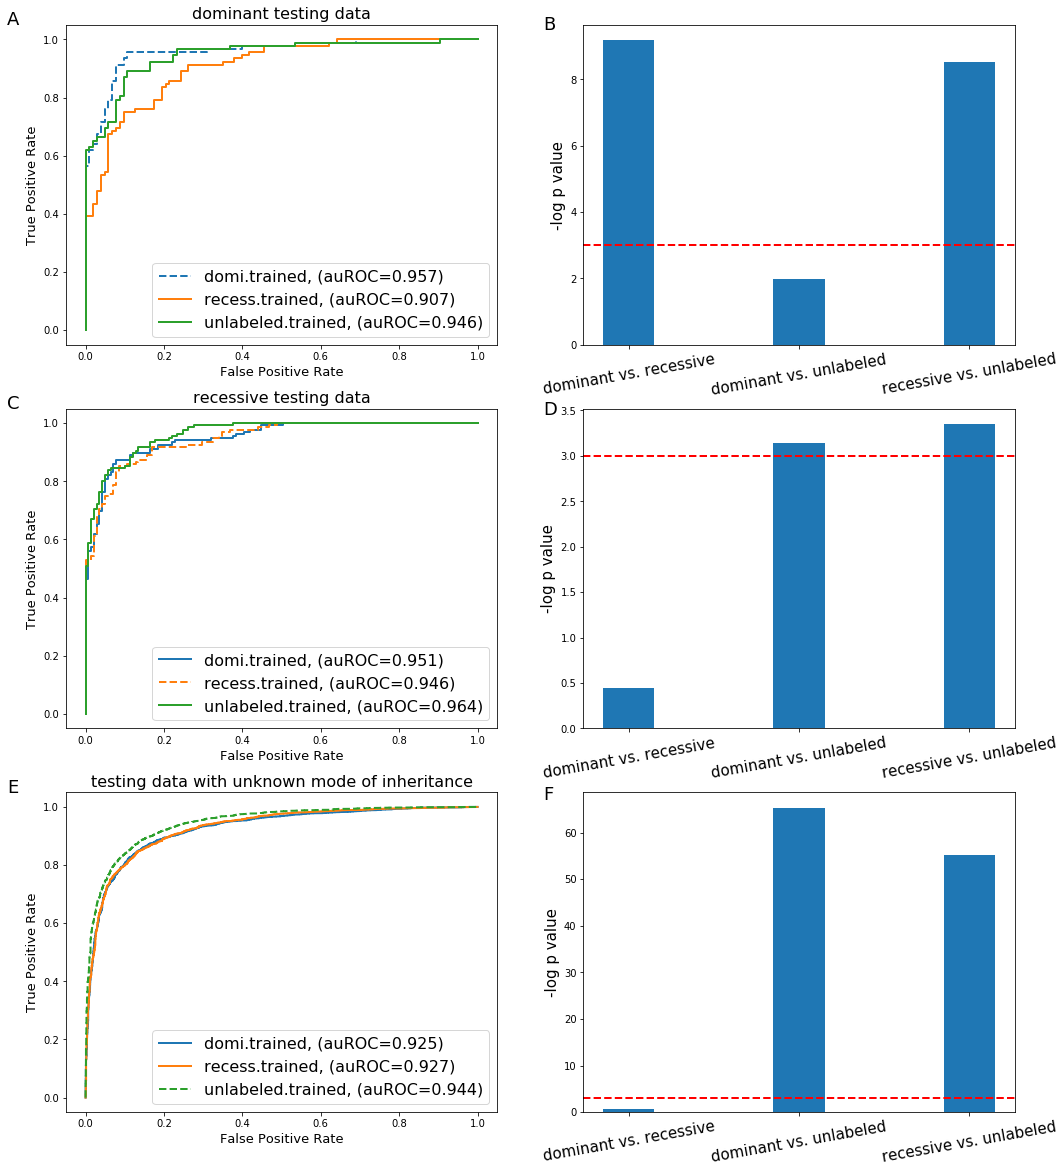

In [11]:
## test
def get_ROC(ax,ytest, ytest_hat, label, lastone = False, x = 'False Positive Rate', y = 'True Positive Rate', title = None, legendloc = 'lower right', lw = 2, linestyle = '-'):
    fpr, tpr, thresholds = roc_curve(ytest, ytest_hat)
    auroc = auc(fpr,tpr)
    ax.plot(fpr, tpr, lw = lw, linestyle = linestyle, label = label +', (auROC=%0.3f)'%auroc)
    if(lastone == True):
        ax.set_xlabel(x,fontsize = 13)
        ax.set_ylabel(y, fontsize = 13)
        ax.set_title(title, fontsize = 16)
        ax.legend(loc='lower right',fontsize = 16)


plt.rcParams['figure.figsize'] = [17,20]
fig, ax = plt.subplots(3,2)

#ORIGINAL
# domi_gb = fitting_gb(X_train_domi, y_train_domi, X_test_domi, y_test_domi, 0.1, 3, 150)
# recess_gb = fitting_gb( X_train_recess, y_train_recess, X_test_recess, y_test_recess, 0.1, 5, 200)
# omit_gb = fitting_gb(X_train, y_train, X_test, y_test, 0.1, 3, 150)



#DOMINANT

domi_cross_gb = fitting_gb(0,0,X_test_domi, y_test_domi,0,0,0, fitmodel = recess_gb[2])
domi_overall_gb = fitting_gb(0,0,X_test_domi, y_test_domi,0,0,0, fitmodel = omit_gb[2])


get_ROC(ax[0,0],domi_gb[0],domi_gb[1], label = 'domi.trained', linestyle = '--')
get_ROC(ax[0,0], domi_gb[0],domi_cross_gb[1],label = 'recess.trained')
get_ROC(ax[0,0], domi_gb[0],domi_overall_gb[1],label = 'unlabeled.trained',lastone = True, title = "dominant testing data")
ax[0,0].text(-0.2, 1.05, 'A', size = 18)


# clust_data = np.array([[1.03e-4], [0.139],[1.97e-4]])
# rowlabel=("dominant vs. recessive", "dominant vs. unlabeled", "recessive vs. unlabeled")
# ax[0,1].axis('off')
# table = ax[0,1].table(cellText = clust_data,rowLabels = rowlabel,loc='center',cellLoc='center',bbox=[0.5,0.4,0.5,0.3])
# table.set_fontsize (16)
# table.scale(1.5, 1.5)

neg_logp= -np.log(0.05)
x_name = ["dominant vs. recessive", "dominant vs. unlabeled", "recessive vs. unlabeled"]
ax[0,1].bar(x_name, -np.log([1.03e-4, 0.139,1.97e-4]), width=0.3)
ax[0,1].text(-0.5, 9.5, 'B', size = 18)
ax[0,1].set_ylabel('-log p value', size = 15)
ax[0,1].axhline(y=neg_logp, linewidth = 2, color='r', linestyle = '--')
ax[0,1].tick_params(axis='x', labelsize=15, rotation = 10)

#RECESSIVE
recess_cross_gb = fitting_gb(0,0, X_test_recess, y_test_recess ,0,0,0, fitmodel = domi_gb[2])
recess_overall_gb = fitting_gb(0,0,X_test_recess, y_test_recess,0,0,0, fitmodel = omit_gb[2])

get_ROC(ax[1,0], recess_gb[0],recess_cross_gb[1], label = "domi.trained")
get_ROC(ax[1,0],recess_gb[0],recess_gb[1], label = "recess.trained", linestyle = '--')
get_ROC(ax[1,0], recess_gb[0], recess_overall_gb[1], label = 'unlabeled.trained', lastone = True, title = "recessive testing data")
ax[1,0].text(-0.2, 1.05, 'C', size = 18)


# ax[1,1].axis('off')
# clust_data = np.array([[0.639],[0.043],[0.035]])
# table = ax[1,1].table(cellText = clust_data,rowLabels = rowlabel,loc='center',cellLoc='center',bbox=[0.5,0.4,0.5,0.3])
# table.set_fontsize (16)
# table.scale(1.5, 1.5)

ax[1,1].bar(x_name, -np.log([0.639,0.043,0.035]), width=0.3)

ax[1,1].text(-0.5, 3.45, 'D', size = 18)
ax[1,1].set_ylabel('-log p value', size = 15)
ax[1,1].axhline(y=neg_logp, linewidth = 2, color='r', linestyle = '--')
ax[1,1].tick_params(axis='x', labelsize=15, rotation = 10)

## omit

omit_domi = fitting_gb(0,0, X_test, y_test,0,0,0, fitmodel = domi_gb[2])
omit_recess = fitting_gb(0,0, X_test, y_test,0,0,0, fitmodel = recess_gb[2])

get_ROC(ax[2,0], omit_gb[0],omit_domi[1], label = "domi.trained")
get_ROC(ax[2,0], omit_gb[0],omit_recess[1], label = "recess.trained")
get_ROC(ax[2,0], omit_gb[0], omit_gb[1], label = 'unlabeled.trained', linestyle = '--', lastone = True, title = "testing data with unknown mode of inheritance")
ax[2,0].text(-0.2, 1.05, 'E', size = 18)




clust_data = np.array([[0.457],[4.13e-29],[1.09e-24]])
# table = ax[2,1].table(cellText = clust_data,rowLabels = rowlabel,loc='center',cellLoc='center',bbox=[0.5,0.4,0.5,0.3])
# table.set_fontsize (16)
# table.scale(1.5, 1.5)
ax[2,1].bar(x_name, -np.log([0.457,4.13e-29,1.09e-24]), width=0.3)


ax[2,1].set_ylabel('-log p value', size = 15)
ax[2,1].text(-0.5, 67, 'F', size = 18)
ax[2,1].axhline(y=neg_logp, linewidth = 2, color='r', linestyle = '--')

ax[2,1].tick_params(axis='x', labelsize=15, rotation = 10)
#ax[2,1].set_xticklabels(fontsize = 15, rotation = 10)
plt.savefig('figure/4_gradientboosting_ROC_cross.pdf',bbox_inches='tight')
plt.show()

In [116]:
np.random.random((10,3))

array([[0.96195611, 0.49927933, 0.4072378 ],
       [0.3921779 , 0.61821181, 0.21169262],
       [0.7740702 , 0.40119483, 0.02366055],
       [0.5494452 , 0.70769998, 0.31814253],
       [0.68693628, 0.44679924, 0.55251682],
       [0.5539531 , 0.60443509, 0.71465586],
       [0.24950702, 0.01702879, 0.73036677],
       [0.9062318 , 0.77733753, 0.41722804],
       [0.76774817, 0.61912132, 0.17758105],
       [0.68374259, 0.97521194, 0.8144347 ]])

In [60]:
np.array([[1.03e-4, 0.139,1.97e-4]]).shape

(1, 3)

In [31]:
-np.log(0.05)

2.995732273553991

In [26]:
domi_delong = pd.DataFrame({'result':domi_gb[0], 'domi':domi_gb[1], 'recess':domi_cross_gb[1], 'omit':domi_overall_gb[1]})
recess_delong = pd.DataFrame({'result':recess_gb[0], 'domi':recess_cross_gb[1], 'recess':recess_gb[1], 'omit':recess_overall_gb[1]})
unlabeled_delong = pd.DataFrame({'result':omit_gb[0],'domi':omit_domi[1], 'recess':omit_recess[1], 'omit':omit_gb[1]})


In [27]:
domi_delong

,result,domi,recess,omit
0,0,-0.896808,-2.740718,-1.376754
1,0,-4.082787,-5.126437,-3.002903
2,1,2.656577,3.709876,3.223028
3,1,0.734799,4.309105,2.602514
4,1,2.875863,3.569306,2.369629
...,...,...,...,...
190,1,4.605025,1.291279,3.971966
191,1,2.856986,3.920539,3.327735
192,0,-2.297616,-3.739169,-2.321189
193,0,0.204052,-2.287503,-1.206831


In [28]:
domi_delong.to_csv('~/work/project/not_conflict/r_noconflict/domi_delong.tsv', sep = '\t',index = False)

recess_delong.to_csv('~/work/project/not_conflict/r_noconflict/recess_delong.tsv', sep = '\t',index = False)
unlabeled_delong.to_csv('~/work/project/not_conflict/r_noconflict/Unlabeled_delong.tsv', sep = '\t',index = False)

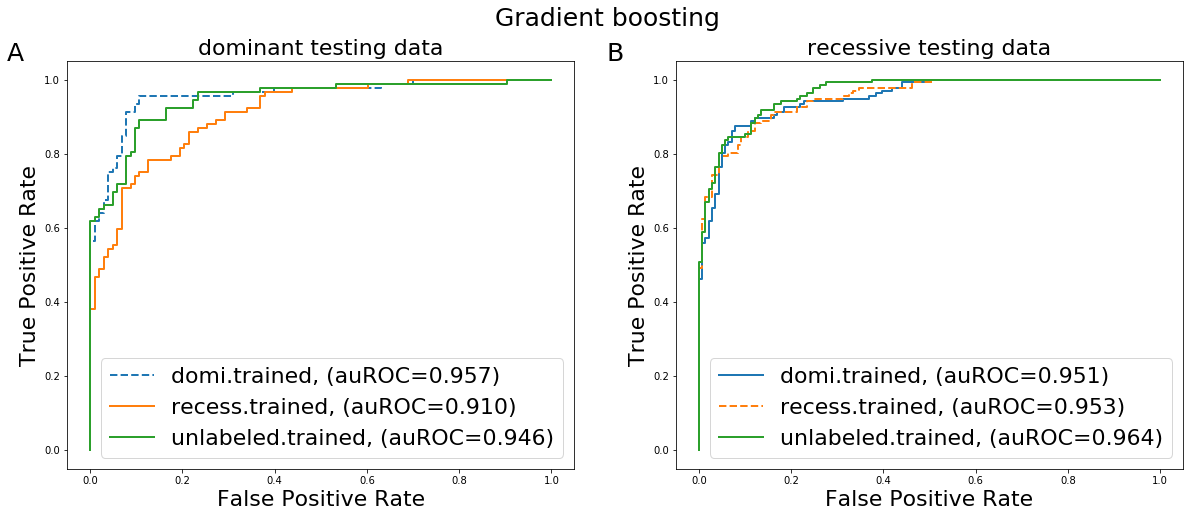

In [25]:
plt.rcParams['figure.figsize'] = [20,7.5]
fig, ax = plt.subplots(1, 2)
fig.suptitle('Gradient boosting', size = 25)


#ORIGINAL
# domi_gb = fitting_gb(X_train_domi, y_train_domi, X_test_domi, y_test_domi, 0.1, 3, 150)
# recess_gb = fitting_gb( X_train_recess, y_train_recess, X_test_recess, y_test_recess, 0.1, 5, 200)
# omit_gb = fitting_gb(X_train, y_train, X_test, y_test, 0.1, 3, 150)



#DOMINANT

#domi_cross_gb = fitting_gb(0,0,X_test_domi, y_test_domi,0,0,0, fitmodel = recess_gb[2])
#domi_overall_gb = fitting_gb(0,0,X_test_domi, y_test_domi,0,0,0, fitmodel = omit_gb[2])


get_ROC(ax[0],domi_gb[0],domi_gb[1], label = 'domi.trained', linestyle = '--')
get_ROC(ax[0], domi_cross_gb[0],domi_cross_gb[1],label = 'recess.trained')
get_ROC(ax[0], domi_overall_gb[0],domi_overall_gb[1],label = 'unlabeled.trained',lastone = True, title = "dominant testing data")
ax[1].text(-1.5, 1.05, 'A', size = 25)



#RECESSIVE
recess_cross_gb = fitting_gb(0,0, X_test_recess, y_test_recess ,0,0,0, fitmodel = domi_gb[2])
recess_overall_gb = fitting_gb(0,0,X_test_recess, y_test_recess,0,0,0, fitmodel = omit_gb[2])

get_ROC(ax[1], recess_cross_gb[0],recess_cross_gb[1], label = "domi.trained")
get_ROC(ax[1],recess_gb[0],recess_gb[1], label = "recess.trained", linestyle = '--')
get_ROC(ax[1], recess_overall_gb[0], recess_overall_gb[1], label = 'unlabeled.trained', lastone = True, title = "recessive testing data")
ax[1].text(-0.2, 1.05, 'B', size = 25)

#plt.savefig('figure/4_gradientboosting_ROC_onlytwo.pdf',bbox_inches='tight')
plt.show()

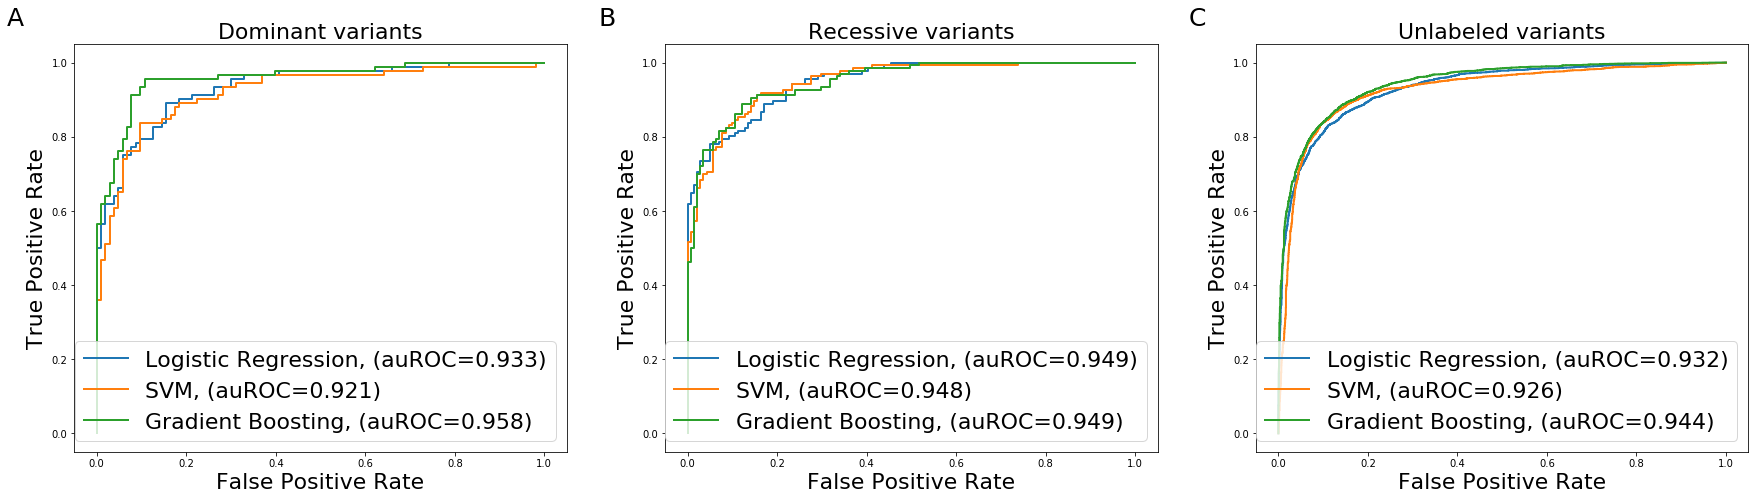

In [31]:
plt.rcParams['figure.figsize'] = [30,7.5]
fig, ax = plt.subplots(1, 3)

get_ROC(ax[0],domi_l2[0],domi_l2[1], label = 'Logistic Regression')
get_ROC(ax[0],svm_domi[0],svm_domi[1], label = 'SVM')
get_ROC(ax[0],domi_gb[0],domi_gb[1], label = 'Gradient Boosting',lastone = True, title = 'Dominant variants')
ax[0].text(-0.2, 1.1, 'A', size = 25)


get_ROC(ax[1],recess_l2[0],recess_l2[1], label = 'Logistic Regression')
get_ROC(ax[1],svm_recess[0],svm_recess[1], label = 'SVM')
get_ROC(ax[1],recess_gb[0],recess_gb[1], label = 'Gradient Boosting',lastone = True, title = 'Recessive variants')

ax[1].text(-0.2, 1.1, 'B', size = 25)




get_ROC(ax[2],omit_l2[0],omit_l2[1], lw = 2,label = 'Logistic Regression' )
get_ROC(ax[2],svm_omit[0],svm_omit[1], lw = 2,label = 'SVM',)
get_ROC(ax[2],omit_gb[0],omit_gb[1], lw = 2,label = 'Gradient Boosting', lastone = True, title = 'Unlabeled variants')


ax[2].text(-0.2, 1.1, 'C', size = 25)
plt.savefig('figure/4_3model_comparison.pdf',bbox_inches='tight')
plt.show()

In [29]:
comparison = pd.DataFrame({'result':y_test, 'logistic':omit_l2[1] ,'svm': svm_omit[1],'boosting': omit_gb[1]})

#comparison.to_csv('~/work/project/not_conflict/r_noconflict/0730/original/overall_comparison.tsv', sep = '\t',index = False)

In [28]:
domi_comparison = pd.DataFrame({'result':y_test_domi, 'logistic':domi_l2[1],'svm': svm_domi[1], 'boosting': domi_gb[1], 'opposite_model':domi_cross_gb[1], 'omit_model':domi_overall_gb[1]})

recess_comparison = pd.DataFrame({'result':y_test_recess, 'logistic':recess_l2[1],'svm': svm_recess[1], 'boosting': recess_gb[1], 'opposite_model':recess_cross_gb[1], 'omit_model':recess_overall_gb[1]})

#domi_comparison.to_csv('~/work/project/not_conflict/r_noconflict/0730/original/dominant_comparison.tsv', sep = '\t',index = False)
#recess_comparison.to_csv('~/work/project/not_conflict/r_noconflict/0730/original/recessive_comparison.tsv', sep = '\t',index = False)

In [18]:
domi_comparison

,result,logistic,svm,boosting,opposite_model,omit_model
0,0,0.056805,-1.240975,-0.896808,-3.348142,-1.376754
1,0,0.015027,-2.305266,-4.082787,-5.421150,-3.002903
2,1,0.945310,1.546526,2.656577,2.979834,3.223028
3,1,0.889233,0.871057,0.734799,4.903363,2.602514
4,1,0.934011,1.702698,2.875863,2.730264,2.369629
...,...,...,...,...,...,...
190,1,0.983708,2.425677,4.605025,0.600090,3.971966
191,1,0.985195,1.777817,2.856986,3.485283,3.327735
192,0,0.210832,-0.949794,-2.297616,-2.548894,-2.321189
193,0,0.145422,-0.920632,0.204052,-2.560930,-1.206831


In [39]:
# check supervised and unsupervised performance

                
# x_ind_column = ['MA_score', 'PROVEN_score','Grantham','HMMEntropy','HMMRelEntropy', 'PredRSAI', 'PredSSE','PredRSAB','PredStabilityH',
#                 'PredBFactorF', 'dscore', 'phyloP_pri', 'phyloP_mam','phyloP_ver','RNA_seq','UNEECON',
#                 'SLR_score', 'LRT_omega',,  'PredRSAB','PredBFactorF', 'PredBFactorM', 'PredBFactorS', 
#                 'PredStabilityM', 'PredStabilityL','PredSSH','PredSSC' ]

# x_ind_col_neg = ['SLR_score','SIFT_score', 'LRT_omega','PROVEN_score'  
#                          , 'PredBFactorM', 'PredBFactorS', 'PredRSAE',
#                          'PredStabilityM', 'PredStabilityL','PredSSH','PredSSC']



x_ind_column = ['SLR_score', 'SIFT_score','LRT_omega', 
                'MA_score', 'PROVEAN_score', 'Grantham', 'HMMEntropy','HMMRelEntropy', 'PredRSAB', 'PredRSAI', 
                'PredRSAE','PredBFactorF', 'PredBFactorM', 'PredBFactorS', 'PredStabilityH','PredStabilityM', 
                'PredStabilityL', 'PredSSE', 'PredSSH','PredSSC', 'dscore', 'phyloP_pri', 'phyloP_mam','phyloP_ver','RNA_seq','UNEECON']


x_ind_col_neg = ['SLR_score', 'SIFT_score','LRT_omega', 'PROVEAN_score','PredRSAE', 'PredBFactorM', 'PredBFactorS',
                'PredStabilityL','PredSSH','PredSSC',]

def ind(x_column, data, neg_col):
    pred = {}
    for column in data[x_column]:
        #print(column)
        y_ind = data.loc[:,column]
        #print(y_ind.shape)
        if(column in x_ind_col_neg):
            #print(y_ind)
            #print('negative')
            y_ind = -y_ind
            #print(y_ind)
            #print('')
        pred[column] = y_ind
    return(pred)





def drawROC2(ytest, ytest_hat, lw=3, linestyle = '--', label = '', lastone = False, MoreThanOnelocation = 'lower right', fontsize = 12, title = '', legendloc = ''):
    fpr, tpr, thresholds = roc_curve(ytest, ytest_hat)
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr, tpr, lw = lw, linestyle = linestyle, label = label + ', (AUC = %0.3f)'%roc_auc)
    if lastone == True:
        if legendloc != '':
            plt.legend(loc='center', bbox_to_anchor= (4, 1.7), ncol=legendloc, borderaxespad=0, frameon=False,fancybox=True, shadow=True)
        else:
            plt.legend(loc = 'lower right', fontsize = 12)
        plt.title(title)
        plt.show()

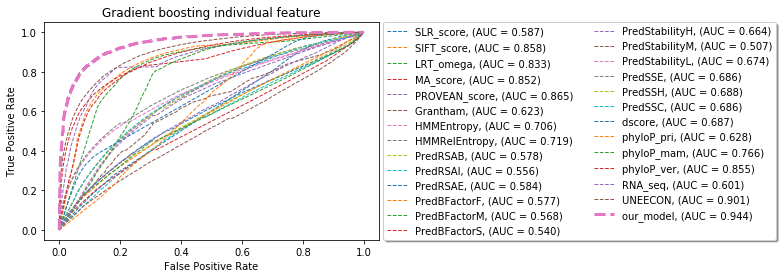

In [40]:

def drawROC2(ytest, ytest_hat, lw=3, linestyle = '--', label = '', lastone = False, MoreThanOnelocation = 'lower right', fontsize = 12, title = '', legendloc = ''):
    fpr, tpr, thresholds = roc_curve(ytest, ytest_hat)
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr, tpr, lw = lw, linestyle = linestyle, label = label + ', (AUC = %0.3f)'%roc_auc)
    if lastone == True:
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        
        if legendloc != '':
            plt.legend(loc='center', bbox_to_anchor= (1.6,0.5), ncol=2,fancybox=True, shadow=True)

        plt.title(title)
        plt.savefig('figure/4_GB_individual_feature.pdf',bbox_inches = "tight")


ind_col = ind(x_ind_column, omit, x_ind_col_neg)
#print(ind_col)
ind_col2 = pd.DataFrame(ind_col) 


plt.rcParams['figure.figsize'] = [6,4]
for i in ind_col2:
    drawROC2(omit.loc[:,'clinvar_result'], ind_col2.loc[:,i], lw = 1, label = i)
drawROC2(omit_gb[0], omit_gb[1], label = 'our_model', lastone = True,legendloc = 5, title = 'Gradient boosting individual feature')


## delete variants with no assertion criteria

In [9]:
x_column = ['location','SIFT_pred','LRT_pred', 'MA_pred', 'PROVEAN_pred', 'SLR_score', 'SIFT_score','LRT_omega', 
                'MA_score', 'PROVEAN_score', 'Grantham', 'HMMEntropy','HMMRelEntropy', 'PredRSAB', 'PredRSAI', 
                'PredRSAE','PredBFactorF', 'PredBFactorM', 'PredBFactorS', 'PredStabilityH','PredStabilityM', 
                'PredStabilityL', 'PredSSE', 'PredSSH','PredSSC', 'dscore', 'phyloP_pri', 'phyloP_mam','phyloP_ver','RNA_seq','UNEECON']


X_train_wloc, X_valid_wloc, X_test_wloc, y_train_wloc, y_valid_wloc, y_test_wloc = split(omit, x_column, y_column)

no_assertion = clinvar[clinvar['info'].str.contains('no_assertion')]['location']
#omit_new = omit[~omit['location'].isin(no_assertion)]

## first, get the training data
X_train_omitnoassertion = X_train_wloc[~X_train_wloc['location'].isin(no_assertion)]
X_valid_omitnoassertion = X_valid_wloc[~X_valid_wloc['location'].isin(no_assertion)]
X_test_omitnoassertion = X_test_wloc[~X_test_wloc['location'].isin(no_assertion)]

#making sure you have the right y to pair
y_trainwloc = pd.DataFrame({'location':X_train_wloc['location'], 'clinvar_result':y_train_wloc})
y_validwloc = pd.DataFrame({'location':X_valid_wloc['location'], 'clinvar_result':y_valid_wloc})
y_testwloc = pd.DataFrame({'location':X_test_wloc['location'], 'clinvar_result':y_test_wloc})


y_trainwloc = y_trainwloc[~y_trainwloc['location'].isin(no_assertion)]['clinvar_result']
y_validwloc = y_validwloc[~y_validwloc['location'].isin(no_assertion)]['clinvar_result']
y_testwloc = y_testwloc[~y_testwloc['location'].isin(no_assertion)]['clinvar_result']

X_train_omitnoassertion = X_train_wloc[~X_train_wloc['location'].isin(no_assertion)].drop(columns = ['location'])
X_valid_omitnoassertion = X_valid_wloc[~X_valid_wloc['location'].isin(no_assertion)].drop(columns = ['location'])
X_test_omitnoassertion = X_test_wloc[~X_test_wloc['location'].isin(no_assertion)].drop(columns = ['location'])


# tuning(X_valid_new, y_valid_new, 'gradient boosting', tuned_parameters)

In [125]:
tuning(X_valid_omitnoassertion, y_validwloc, 'gradient boosting', tuned_parameters)

# Tuning hyper-parameters for recall



/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters set found on development set:
{'learning_rate': 0.15, 'max_depth': 8, 'n_estimators': 150}
With score : 0.506

Grid scores on development set:

0.497 (+/-0.001) for {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
0.493 (+/-0.007) for {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 150}
0.496 (+/-0.006) for {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
0.500 (+/-0.004) for {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
0.500 (+/-0.008) for {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 150}
0.503 (+/-0.005) for {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}
0.501 (+/-0.004) for {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 100}
0.494 (+/-0.007) for {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 150}
0.499 (+/-0.000) for {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 200}
0.496 (+/-0.001) for {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
0.500 (+/-0.005) for 

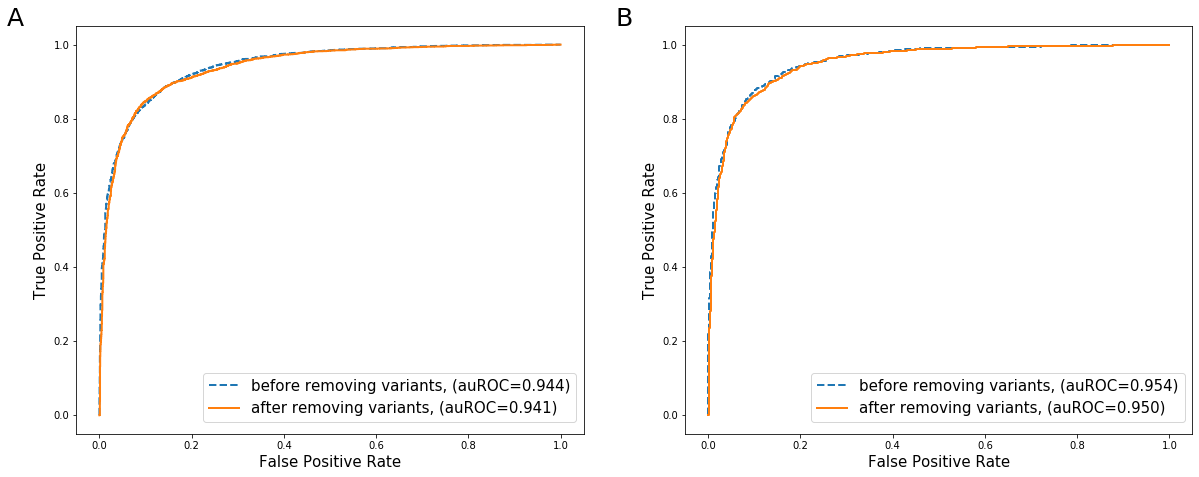

In [19]:
# def get_ROC(ax,ytest, ytest_hat, label, lastone = False, x = 'False Positive Rate', y = 'True Positive Rate', title = None, legendloc = 'lower right', lw = 2, linestyle = '-'):
#     fpr, tpr, thresholds = roc_curve(ytest, ytest_hat)
#     auroc = auc(fpr,tpr)
#     ax.plot(fpr, tpr, lw = lw, linestyle = linestyle, label = label +', (auROC=%0.3f)'%auroc)
#     if(lastone == True):
#         ax.set_xlabel(x,fontsize = 15)
#         ax.set_ylabel(y, fontsize = 15)
#         ax.legend(loc='lower right',fontsize = 15,bbox_to_anchor= (1,0.01))


#omit_gb = fitting_gb(X_train, y_train, X_test, y_test, 0.1, 3, 150)
#omit_gb_new = fitting_gb(X_train_omitnoassertion, y_trainwloc, X_test, y_test, 0.15, 8, 150)

plt.rcParams['figure.figsize'] = [20,7.5]
fig, ax = plt.subplots(1,2)

get_ROC(ax[0],omit_gb[0], omit_gb[1], label = 'before removing variants', lw = 2, linestyle = '--')
get_ROC(ax[0],omit_gb[0], omit_gb_new[1], label = 'after removing variants', lw = 2, lastone = True)
ax[0].text(-0.2, 1.05, 'A', size = 25)

# testing how they performed in testing data that no assertion criteria are removed
##original model (our model)
omitgb_test_omit = fitting_gb(X_train, y_train, X_test_omitnoassertion, y_testwloc, 0.1, 5, 200)
## model trained without variant that have no-assertion criteria
omitgb_omit_test_omited = fitting_gb(X_train_omitnoassertion, y_trainwloc, X_test_omitnoassertion, y_testwloc, 0.15, 8, 150)


get_ROC(ax[1],omitgb_test_omit[0], omitgb_test_omit[1], label = 'before removing variants', lw = 2, linestyle='--')
get_ROC(ax[1],omitgb_omit_test_omited[0], omitgb_omit_test_omited[1], label = 'after removing variants', lw = 2, lastone = True)
ax[1].text(-0.2, 1.05, 'B', size = 25)


plt.savefig('figure/4_remove_noassertion_sametestdata.pdf', bbox_inches = "tight")

In [20]:
#save for future delong test comparison
omit_remove_partial = pd.DataFrame({'result':omit_gb[0], 'original':omit_gb[1], 'remove':omit_gb_new[1]})
omit_remove_all = pd.DataFrame({'result':omitgb_test_omit[0], 'original':omitgb_test_omit[1], 'remove':omitgb_omit_test_omited[1]})
omit_remove_partial.to_csv('~/work/project/not_conflict/r_noconflict/omit_remove_partial.tsv', sep = '\t', index = False)
omit_remove_all.to_csv('~/work/project/not_conflict/r_noconflict/omit_remove_all.tsv', sep = '\t', index = False)


[[93 10]
 [ 6 86]]


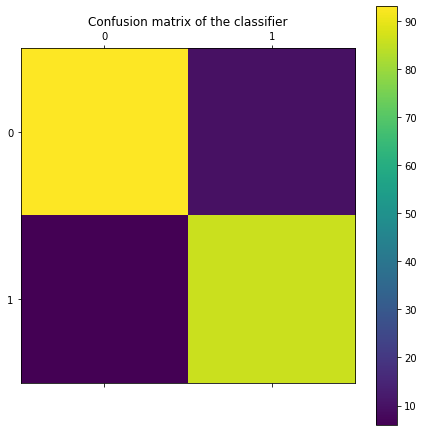

[[95  8]
 [12 80]]


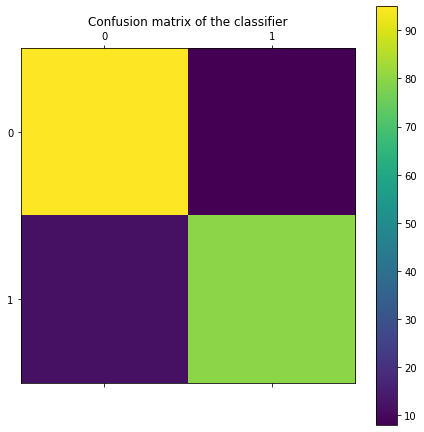

[[85 18]
 [ 4 88]]


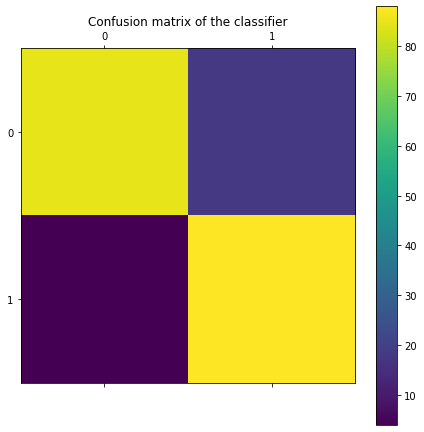

[[103   0]
 [ 92   0]]


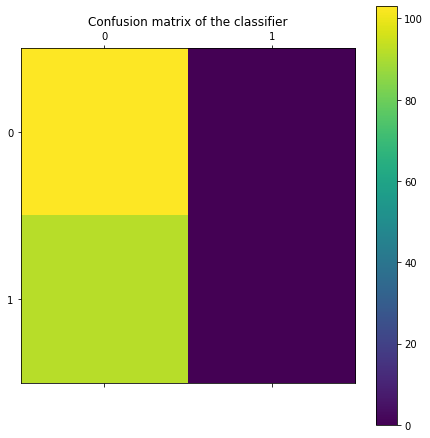

In [29]:
# decide cutoff 
from sklearn.metrics import confusion_matrix
import pylab as pl

def confusionmatrix(correct, predict, cutoff):
    predict_binary = np.copy(predict)
    predict_binary[predict_binary > cutoff ] = 1
    predict_binary[predict_binary <=  cutoff ] = 0
    cm = confusion_matrix(correct, predict_binary)
    print(cm)
    pl.matshow(cm)
    pl.title('Confusion matrix of the classifier')
    pl.colorbar()
    pl.show()
    
    
    
confusionmatrix(domi_gb[0], domi_gb[1], 0 )
confusionmatrix(domi_gb[0], domi_gb[1],0.5)
confusionmatrix(domi_gb[0], domi_gb[1],-0.5)
confusionmatrix(domi_gb[0], domi_gb[1],1)

(array([3229.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3035.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

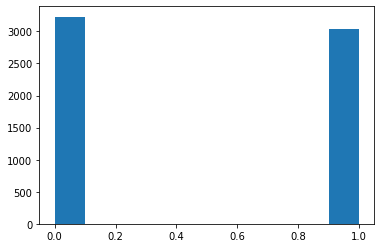

In [151]:
plt.hist(omit_gb[1])

In [8]:
column_list = ['chrom','pos','ID','ref','alt','qual','filter','info']
clinvar = pd.read_csv('/storage/home/jkl5991/work/project/original_data/clinvar_20200113.vcf', sep='\t', header=None, comment='#', names = column_list)
clinvar.head()
clinvar.columns = column_list
clinvar = clinvar[clinvar['ref'].str.len() == clinvar['alt'].str.len()]
clinvar = clinvar.assign( location = 'chr' + clinvar['chrom'].astype(str) + '-' + (clinvar['pos']-1).astype(str) +\
                     '-' + clinvar['pos'].astype(str) +'-'+ clinvar['ref'].astype(str) +'-'+ clinvar['alt'].astype(str))

/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [14]:
## get correct/incorrect index number

def prediction_location(predict, correct):
    false_nagative= false_positive= true_positive= true_negative = 0
    # transferring it into binary data
    
    predict_binary = predict
    predict_binary[predict_binary > 0 ] = 1
    predict_binary[predict_binary < 0 ] = 0
    wrong_prediction = np.where(predict_binary != correct)
    
    #positive = 1 = pathogenic, negative =0 = benign
    true_positive = np.where(np.logical_and(correct == 1, predict_binary == 1))
    true_negative = np.where(np.logical_and(correct == 0, predict_binary == 0))
    false_positive = np.where(np.logical_and(correct == 0, predict_binary == 1))
    false_negative = np.where(np.logical_and(correct == 1, predict_binary == 0))
    
    true_prediction = np.where(predict_binary == correct)
    
    return(true_prediction, true_positive, true_negative, wrong_prediction, false_positive, false_negative)


## get any data location (right, wrong, fp, fn)

def get_location(predict, correct, original_df, type_of_result):
    # get their index number
    df_pos = prediction_location(predict, correct)
    
    # correspond to original data (get location information)
    check_df = split(original_df, ['location'], 'clinvar_result')
    location = check_df[2] #X_test
    
    #get location informaiton
    if(type_of_result == 'right'):
        pos = 0
    elif(type_of_result =='wrong'):
        pos = 3
    elif(type_of_result == 'false_positive'):
        pos = 4
    elif(type_of_result == 'false_negative'):
        pos = 5
    elif(type_of_result == 'true_positive'):
        pos = 1
    elif(type_of_result == 'true_negative'):
        pos = 2
    
    return (location.iloc[np.r_[df_pos[pos][0]],:])


## match the location with clinvar data, also check if there are any specific pattern
def clinvar_find(targetloc, clinvardf, findpattern = None):
    count = 'blank'
    wanted = clinvardf.loc[clinvardf['location'].isin(targetloc['location'])]
    if(findpattern != None):
        count = wanted[wanted['info'].str.contains(findpattern)].shape[0]
    return(wanted, count)


def draw_hist(list_of_values, names, title):
    plt.figure(figsize=(8, 4))
    for i in range(len(list_of_values)):
        plt.bar(names[i], list_of_values[i])
    plt.suptitle(title)
    plt.show()
        
   


## mix all the functions above in a single function

def draw_clinvar_find(which_result, originaldf, clinvardf, findpattern, predict, correct):
    loc = get_location(predict, correct, originaldf, which_result)
    count = []
    for i in findpattern:
        count.append(clinvar_find(loc, clinvardf, i)[1])
    draw_hist(count, findpattern, which_result)
    return(count)

In [21]:
basic_check = ['single_submitter', 'multiple_submitters', 'no_assertion']
further_check = ['conflicting_interpretations', 'no_interpretation',  'review_by_expert','practice_guideline']

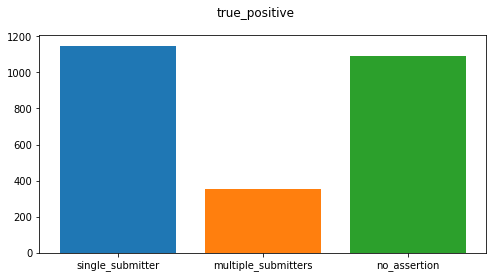

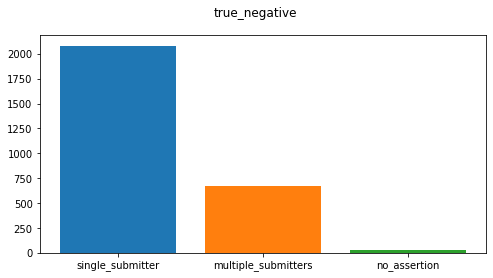

In [22]:
tp = draw_clinvar_find('true_positive', omit, clinvar, basic_check,omit_gb[1], omit_gb[0])
tn = draw_clinvar_find('true_negative', omit, clinvar, basic_check,omit_gb[1], omit_gb[0])

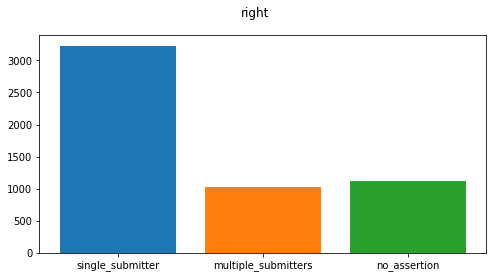

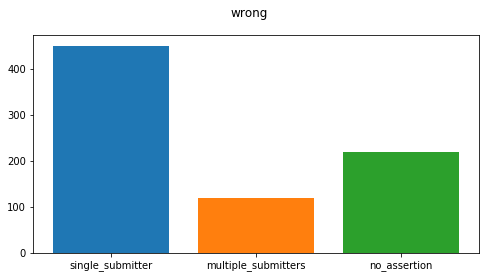

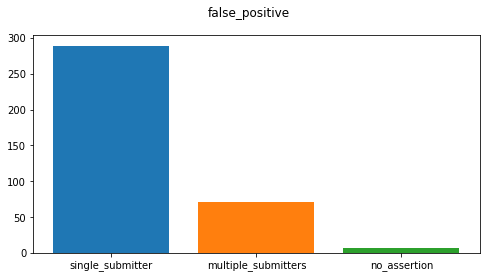

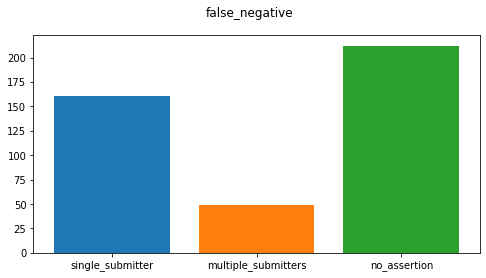

In [23]:
right = draw_clinvar_find('right', omit, clinvar, basic_check,omit_gb[1], omit_gb[0])
wrong = draw_clinvar_find('wrong', omit, clinvar, basic_check,omit_gb[1], omit_gb[0])
fp = draw_clinvar_find('false_positive', omit, clinvar, basic_check,omit_gb[1], omit_gb[0])
fn = draw_clinvar_find('false_negative', omit, clinvar, basic_check,omit_gb[1], omit_gb[0])


In [16]:
#subplot

def pie(ax, data, title):
    total = data[0] + data[1] + data[2]
    size = []
    for i in data:
        size.append(100*i/total)
    #explode = (0, 0, 0.1)
    tag = ['single_submitter', 'multiple_submitters', 'no_assertion']
    
    ax.pie(size, autopct='%1.1f%%',startangle=90,wedgeprops={'alpha':0.8})
    ax.axis('equal') 
    ax.title.set_text(title)
    
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center')

    

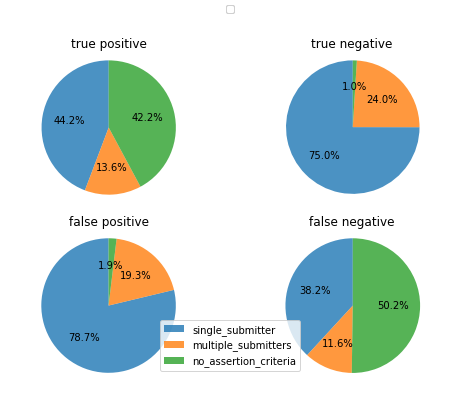

In [17]:
plt.rcParams['figure.figsize'] = [8,6]
fig,ax = plt.subplots(2,2)
tag = ['single_submitter', 'multiple_submitters', 'no_assertion_criteria']
pie(ax[0,0],tp, 'true positive')
pie(ax[0,1],tn, 'true negative')
pie(ax[1,0],fp, 'false positive')
pie(ax[1,1],fn, 'false negative')

fig.legend(tag, bbox_to_anchor=(0.53, 0.21))


#plt.savefig('figure/4_pie_tp_tn_fp_fn.pdf',bbox_inches = "tight")

In [20]:
print(tp)
print(tn)
print(fp)
print(fn)

[1147, 353, 1093]
[2080, 667, 27]
[289, 71, 7]
[161, 49, 212]


In [19]:
tn

[2080, 667, 27]

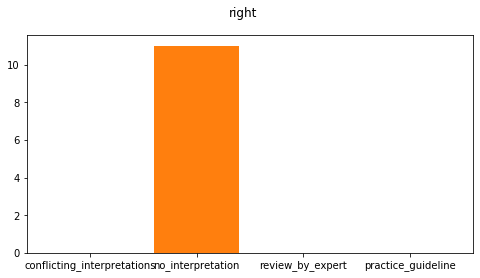

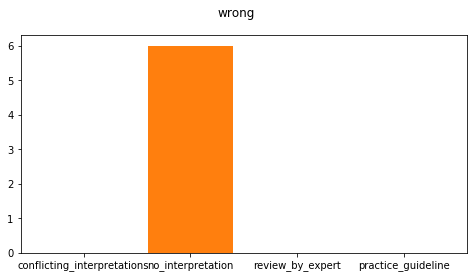

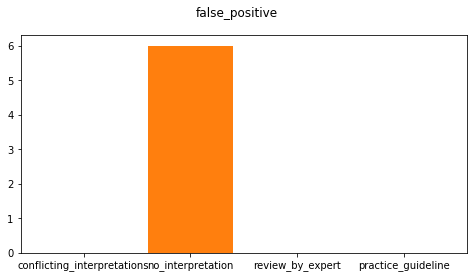

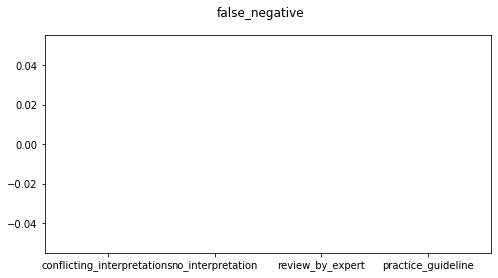

[0, 0, 0, 0]

In [23]:
draw_clinvar_find('right', omit, clinvar, further_check, omit_gb[1], omit_gb[0])
draw_clinvar_find('wrong', omit, clinvar, further_check, omit_gb[1], omit_gb[0])
draw_clinvar_find('false_positive', omit, clinvar, further_check, omit_gb[1], omit_gb[0])
draw_clinvar_find('false_negative', omit, clinvar, further_check, omit_gb[1], omit_gb[0])


In [94]:
ax

array([<matplotlib.axes._subplots.AxesSubplot object at 0x2b99ce6940b8>,
      dtype=object)

In [43]:
def chisquare(array1, array2):
    chisq, pvalue, table = proportion.proportions_chisquare(array1, array2)
    print('Results are ','chisq =%.3f, pvalue = %.5f'%(chisq, pvalue))

In [44]:
from scipy.stats import chi2_contingency
def chi2(arr1, arr2):
    pvalue = chi2_contingency([arr1, arr2])[1]
    print('p value =', pvalue , '\n')

    

In [45]:
#comparing chi square result

print('comparison between having submitters and not having submitter:')
chi2([right[0] + right[1], fp[0] + fp[1], fn[0] + fn[1]], [right[2], fp[2], fn[2]])

print('comparison between having one and not having submitter:')
chi2([right[0] , fp[0] , fn[0]], [right[2], fp[2], fn[2]])

print('comparison between single submitter and multiple submitters:')
chi2([right[0], fp[0], fn[0]], [right[1], fp[1], fn[1]])




comparison between having submitters and not having submitter:
p value = 2.1889442855481075e-63 

comparison between having one and not having submitter:
p value = 3.4297244505853295e-58 

comparison between single submitter and multiple submitters:
p value = 0.1825141855014456 



In [136]:
#remove no_assertion_criteria_provided data
no_assertion = clinvar[clinvar['info'].str.contains('no_assertion')]['location']
omit_new = omit[~omit['location'].isin(no_assertion)]

no_interpretation = clinvar[clinvar['info'].str.contains('no_interpretation')]['location']
omit_new = omit_new[~omit_new['location'].isin(no_interpretation)]

In [47]:
omit_new.to_csv('omit_with_criteria.tsv', sep = '\t',index = False)

In [107]:
clinvar_find(omit_new, clinvar, findpattern ='no_assertion')[1]

0

In [147]:
omit_new.shape
X_train_new, X_valid_new, X_test_new, y_train_new, y_valid_new, y_test_new = split(omit_new, x_column, y_column)

In [145]:
x_column

['location',
 'SIFT_pred',
 'LRT_pred',
 'MA_pred',
 'PROVEAN_pred',
 'SLR_score',
 'SIFT_score',
 'LRT_omega',
 'MA_score',
 'PROVEAN_score',
 'Grantham',
 'HMMEntropy',
 'HMMRelEntropy',
 'PredRSAB',
 'PredRSAI',
 'PredRSAE',
 'PredBFactorF',
 'PredBFactorM',
 'PredBFactorS',
 'PredStabilityH',
 'PredStabilityM',
 'PredStabilityL',
 'PredSSE',
 'PredSSH',
 'PredSSC',
 'dscore',
 'phyloP_pri',
 'phyloP_mam',
 'phyloP_ver',
 'RNA_seq']

In [48]:
X_train_new, X_valid_new, X_test_new, y_train_new, y_valid_new, y_test_new = split(omit_new, x_column, y_column)
tuning(X_valid_new, y_valid_new, 'gradient boosting', tuned_parameters)

# Tuning hyper-parameters for recall



/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters set found on development set:
{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}
With score : 0.873

Grid scores on development set:

0.865 (+/-0.007) for {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
0.867 (+/-0.005) for {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 150}
0.869 (+/-0.006) for {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
0.867 (+/-0.003) for {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
0.871 (+/-0.004) for {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 150}
0.873 (+/-0.001) for {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}
0.865 (+/-0.006) for {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 100}
0.866 (+/-0.010) for {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 150}
0.868 (+/-0.006) for {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 200}
0.867 (+/-0.007) for {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
0.866 (+/-0.004) for 

In [18]:
def get_ROC(ax,ytest, ytest_hat, label, lastone = False, x = 'False Positive Rate', y = 'True Positive Rate', title = None, legendloc = 'lower right', lw = 2, linestyle = '-'):
    fpr, tpr, thresholds = roc_curve(ytest, ytest_hat)
    auroc = auc(fpr,tpr)
    ax.plot(fpr, tpr, lw = lw, linestyle = linestyle, label = label +', (auROC=%0.3f)'%auroc)
    if(lastone == True):
        ax.set_xlabel(x,fontsize = 14)
        ax.set_ylabel(y, fontsize = 14)
        ax.legend(loc='lower right',fontsize = 14,bbox_to_anchor= (1.92,0.02))



omit_gb_new = fitting_gb(X_train_new, y_train_new, X_test_new, y_test_new, 0.1, 5, 200)

plt.rcParams['figure.figsize'] = [6,4]
fig, ax = plt.subplots()
#omit_gb = fitting_gb(X_train, y_train, X_test, y_test, 0.1, 3, 150)
get_ROC(ax,omit_gb[0], omit_gb[1], label = 'our model', lw = 2)
get_ROC(ax,omit_gb_new[0], omit_gb_new[1], label = 'our model after removing variants with no assertion criteria', lw = 2, lastone = True)

#plt.savefig('figure/4_remove_no_assertion.pdf', bbox_inches = "tight")

NameError: name 'X_train_new' is not defined

In [19]:
omit_gb_new_try = fitting_gb(X_train_new, y_train_new, X_test, y_test, 0.1, 5, 200)

NameError: name 'X_train_new' is not defined

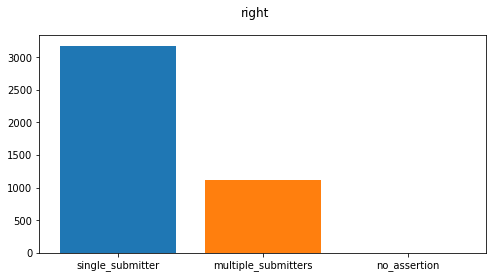

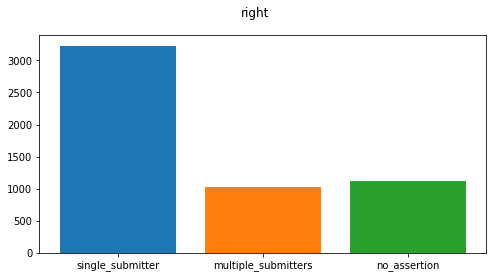

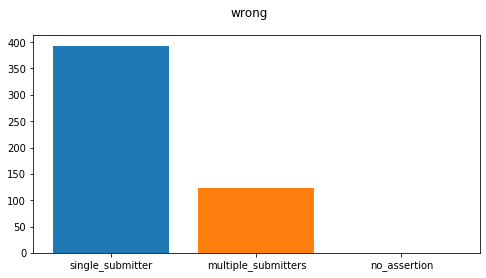

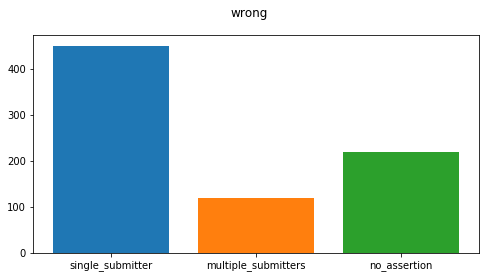

[450, 120, 219]

In [135]:
# double check that there is no data that have no assertion criteria in omit_new
draw_clinvar_find('right', omit_new, clinvar, basic_check,omit_gb_new[1], omit_gb_new[0])
draw_clinvar_find('right', omit, clinvar, basic_check,omit_gb[1], omit_gb[0])

draw_clinvar_find('wrong', omit_new, clinvar, basic_check,omit_gb_new[1], omit_gb_new[0])
draw_clinvar_find('wrong', omit, clinvar, basic_check,omit_gb[1], omit_gb[0])

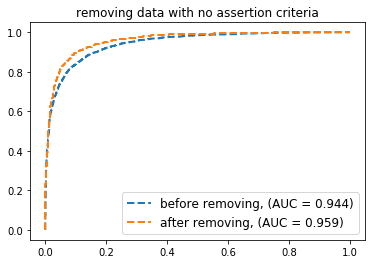

In [32]:
omit_gb_new = fitting_gb(X_train_new, y_train_new, X_test_new, y_test_new, 0.05, 8, 200)
drawROC(omit_gb[0], omit_gb[1], label = 'before removing', lw = 2)
drawROC(omit_gb_new[0], omit_gb_new[1], label = 'after removing', lw = 2, lastone = True, title = 'removing data with no assertion criteria')

In [27]:
# protein structure prediction

def find_any_column(df, predict , correct , type_of_result, column):
    
    if(type_of_result == 'false_positive'):
        pos = 4
    elif(type_of_result == 'false_negative'):
        pos = 5
    elif(type_of_result == 'true_positive'):
        pos = 1
    elif(type_of_result == 'true_negative'):
        pos = 2
    loc = prediction_location(predict, correct)[pos][0]
    return(df.iloc[np.r_[loc],column])
    

In [20]:
import seaborn as sns

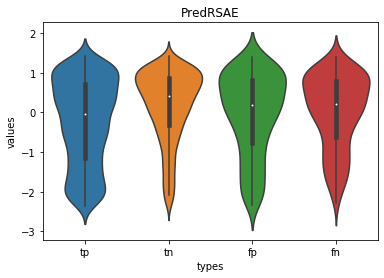

In [185]:
plt.rcParams['figure.figsize'] = [6,4]
ax = sns.violinplot(x = 'types', y = 'values', data = df_violin, scale = "width")
ax.set_title('%s'%('PredRSAE'))
#plt.savefig('figure/4_violinplot_RSAE.pdf')

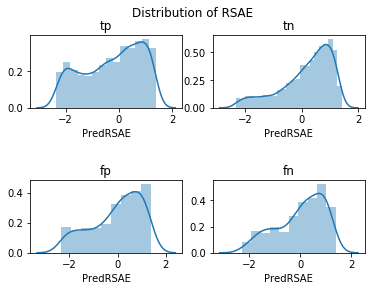

In [25]:
import seaborn as sns

fig, axes = plt.subplots(nrows=2, ncols = 2)
fig.subplots_adjust(hspace=1)
fig.suptitle('Distribution of %s'%('RSAE'))

for ax, feature, name in zip(axes.flatten(), [tp, tn, fp, fn],['tp', 'tn', 'fp','fn']): 
    sns.distplot(feature, ax=ax)
    
    ax.set(title=name)
plt.show()

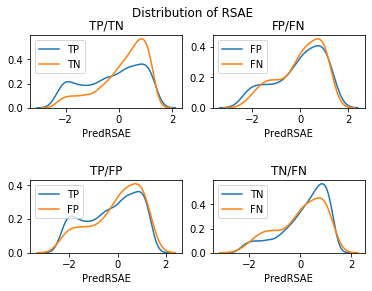

In [28]:

fig, axes = plt.subplots(nrows=2, ncols = 2)
fig.subplots_adjust(hspace=1)
fig.suptitle('Distribution of %s'%('RSAE'))


for ax, feature1, feature2, name in zip(axes.flatten(), [tp, fp, tp, tn],[tn, fn, fp, fn],['TP/TN', 'FP/FN', 'TP/FP','TN/FN']): 
    sns.distplot(feature1, ax = ax, hist = False, label = name[:2])
    sns.distplot(feature2, ax = ax, hist = False, label = name[3:])
    
    
    ax.set(title=name)
plt.show()

In [118]:
# use both statmodels and scipy to double check
# there is significant difference between tp and tn 

## this is an parametric test(required them to follow normal distribution)
## we should use non parametric test if not assumed the sampled distribution is normal distribution 
import statsmodels
print(statsmodels.stats.weightstats.ttest_ind(tp, tn))

from scipy.stats import ttest_ind
print(ttest_ind(tp, tn))

(-14.90625022641073, 2.772770261458215e-49, 5454.0)
Ttest_indResult(statistic=-14.906250226410732, pvalue=2.7727702614580966e-49)


In [223]:
from scipy import stats


In [224]:
# there is no significant difference between all the correctly predicted and incorrectly predicted sample (in total)
print("p values is %s"%(ttest_ind(correct, incorrect)[1]))
# but there is significantly difference between the correctly predicted and incorrectly predicted sample
# in both benign and pathogenic groups
print("p values is %s"%(ttest_ind(tp, fp)[1]))
print("p values is %s"%(ttest_ind(tn, fn)[1]))


NameError: name 'ttest_ind' is not defined

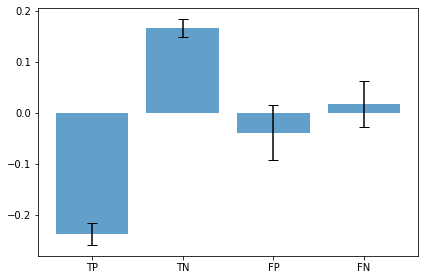

In [26]:
names = ['TP', 'TN', 'FP', 'FN']
means = [tp.mean(), tn.mean(), fp.mean(), fn.mean()]
stds = [tp.sem(), tn.sem(), fp.sem(), fn.sem()]
fig, ax = plt.subplots()
ax.bar(np.arange(4),means, yerr = stds, align = 'center', alpha = 0.7, ecolor = 'black', capsize= 5)
ax.set_xticks(np.arange(4))
ax.set_xticklabels(names)
plt.tight_layout()

In [243]:
tp.sem

0.02118413382504548

In [23]:
def overall(df, predict , correct , col, col_name, savename):
    tp = find_any_column(df, predict,  correct, 'true_positive',col) 
    tn = find_any_column(df, predict,  correct, 'true_negative',col) 
    fp = find_any_column(df, predict,  correct, 'false_positive',col) 
    fn = find_any_column(df, predict,  correct, 'false_negative',col) 

    
    # draw violin plot
    df1 = pd.DataFrame(
    { 'values': tp,
     'types': 'tp'    
    })

    df2 = pd.DataFrame(
    { 'values': tn,
     'types': 'tn'    
    })

    df3 = pd.DataFrame(
    { 'values': fp,
     'types': 'fp'    
    })

    df4 = pd.DataFrame(
    { 'values': fn,
     'types': 'fn'    
    })

    df_violin = pd.concat([df1, df2, df3, df4])
    ax = sns.violinplot(x = 'types', y = 'values', data = df_violin, x_axis = False)
    ax.set_title('%s'%(col_name))
    plt.savefig(savename)
    
    
    # calculate p value
    #print("p values between correct and incorrect groups is %s"%(ttest_ind(correct, incorrect)[1]))
    print("p values between correct and incorrect groups is %s \n"%(stats.ks_2samp(correct, incorrect)[1]))

    #print("p values between tp and fp is %s"%(ttest_ind(tp, fp)[1]))
    print("p values between tp and fp is %s \n"%(stats.ks_2samp(tp, fp)[1]))

    #print("p values between tn and fn is %s"%(ttest_ind(tn, fn)[1]))
    print("p values between tn and fn is %s \n"%(stats.ks_2samp(tn, fn)[1]))
 
    print("p values between tp and tn is %s \n"%(stats.ks_2samp(tn, tp)[1]))

    print("p values between fp and fn is %s \n"%(stats.ks_2samp(fp, fn)[1]))
    
    print("p values between tp and fn is %s \n"%(stats.ks_2samp(tp, fn)[1]))
    
    print("p values between tn and fp is %s \n"%(stats.ks_2samp(tn, fp)[1]))

    print(len(df1), len(df2), len(df3), len(df4))
    

In [365]:
#pip install statannot

  Using cached https://files.pythonhosted.org/packages/0f/3a/e579d7e3b855586e468375251ec093142d67c5f8ccd76482492f2a474862/statannot-0.2.3-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [366]:
from statannot import add_stat_annotation

In [28]:
## Mann-Whitney
from statannot import add_stat_annotation
def violin_box(df, predict , correct , col, col_name):
    TP = find_any_column(df, predict,  correct, 'true_positive',col) 
    TN = find_any_column(df, predict,  correct, 'true_negative',col) 
    FP = find_any_column(df, predict,  correct, 'false_positive',col) 
    FN = find_any_column(df, predict,  correct, 'false_negative',col) 

    
    # creating DataFrame for drawing violin plot
    df1 = pd.DataFrame(
    { 'values': TP,
     'types': 'True',
     'clinvar':'Pathogenic'
    })
    df2 = pd.DataFrame(
    { 'values': TN,
     'types': 'True',
     'clinvar':'Benign'
    })
    df3 = pd.DataFrame(
    { 'values': FP,
     'types': 'False',
     'clinvar':'Benign'
    })
    df4 = pd.DataFrame(
    { 'values': FN,
     'types': 'False',  
     'clinvar':'Pathogenic'
    })
    
    df_violin = pd.concat([df1, df2, df3, df4])
    plt.rcParams['figure.figsize'] = [6,3]
    
    ax = sns.violinplot(x = 'clinvar', y = 'values',hue = 'types', data = df_violin,x_axis = False, inner = "box")
    ax.legend(loc='lower right',fontsize = 13,bbox_to_anchor = (1.3,0.7))
  
  
    sns.set_style("whitegrid")
    ax.grid(False)
    sns.set(font_scale=1.2)
    
    ## add stars for p-values
    test_results = add_stat_annotation(ax, data=df_violin, x='clinvar', y='values', hue='types',
                                   box_pairs=[(('Pathogenic','True'),('Pathogenic','False')),
                                              (('Benign','True'),('Benign','False')),
                                              (('Pathogenic','True'),('Benign','True'))
                                             ],
                                   test='Mann-Whitney',text_format='star',
                                   loc='outside', verbose=2)
    ax.set(xlabel=None)
    ax.set_title(col_name)
    
    print(len(df1), len(df2), len(df3), len(df4))
    
    savename = 'figure/4_violin'+col_name+'.pdf'
    plt.savefig(savename,bbox_inches='tight')
    
     
    

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Benign_True v.s. Benign_False: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.095e-03 U_stat=5.779e+05
Pathogenic_True v.s. Pathogenic_False: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.311e-04 U_stat=5.050e+05
Pathogenic_True v.s. Benign_True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.142e-39 U_stat=2.952e+06
2651 2805 374 434


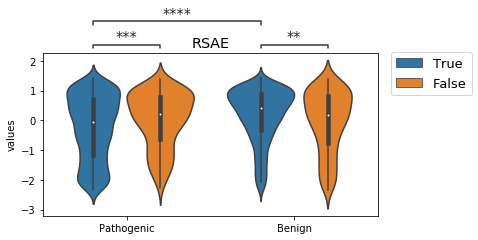

In [29]:
violin_box(X_test, omit_gb[1],  omit_gb[0], 14,'RSAE')

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Benign_True v.s. Benign_False: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.095e-03 U_stat=5.779e+05
Pathogenic_True v.s. Pathogenic_False: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.311e-04 U_stat=5.050e+05
Pathogenic_True v.s. Benign_True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.142e-39 U_stat=2.952e+06


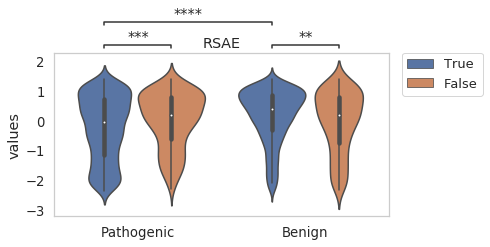

In [436]:
violin_box(X_test, omit_gb[1],  omit_gb[0], 14,'RSAE')

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Benign_True v.s. Benign_False: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.992e-02 U_stat=4.833e+05
Pathogenic_True v.s. Pathogenic_False: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.343e-03 U_stat=6.356e+05
Pathogenic_True v.s. Benign_True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.182e-34 U_stat=4.429e+06


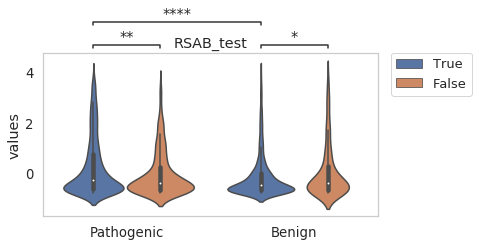

In [457]:
violin_box(X_test, omit_gb[1],  omit_gb[0], 12,'RSAB_test')

In [228]:
import scipy

In [145]:
X_test.columns

Index(['SIFT_pred', 'LRT_pred', 'MA_pred', 'PROVEN_pred', 'SLR_score',
       'SIFT_score', 'LRT_omega', 'MA_score', 'PROVEN_score', 'Grantham',
       'HMMEntropy', 'HMMRelEntropy', 'PredRSAB', 'PredRSAI', 'PredRSAE',
       'PredBFactorF', 'PredBFactorM', 'PredBFactorS', 'PredStabilityH',
       'PredStabilityM', 'PredStabilityL', 'PredSSE', 'PredSSH', 'PredSSC',
       'dscore', 'phyloP_pri', 'phyloP_mam', 'phyloP_ver', 'RNA_seq',
       'UNEECON'],
      dtype='object')

In [455]:
X_test.columns[12]

'PredRSAB'

p values between correct and incorrect groups is 2.1474110704258036e-10 

p values between tp and fp is 7.882583474838611e-15 

p values between tn and fn is 2.886579864025407e-15 

p values between tp and tn is 0.9971045388729833 

p values between fp and fn is 6.535101658140177e-22 

p values between tp and fn is 1.4965223225786192e-97 

p values between tn and fp is 6.661338147750939e-16 



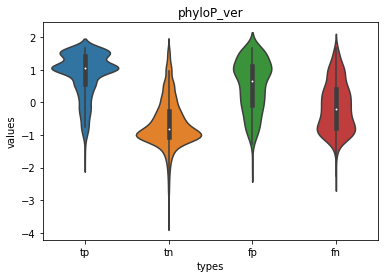

In [232]:
plt.rcParams['figure.figsize'] = [6,4]
overall(X_test, omit_gb[1],  omit_gb[0], 27, 'phyloP_ver', 'figure/4_violin_plot_phyloP_ver.pdf')

p values between correct and incorrect groups is 1.0590493269437452e-09 

p values between tp and fp is 1.2212453270876722e-15 

p values between tn and fn is 1.3397061238151764e-12 

p values between tp and tn is 0.9971045388729833 

p values between fp and fn is 5.833347311316177e-50 

p values between tp and fn is 3.0206487128870745e-149 

p values between tn and fp is 6.661338147750939e-16 



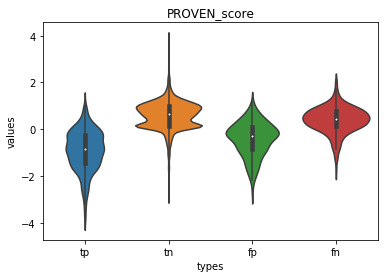

In [230]:
plt.rcParams['figure.figsize'] = [6,4]
overall(X_test, omit_gb[1],  omit_gb[0], 8, 'PROVEN_score', 'figure/4_violin_plot_PROVEN.pdf')

p values between correct and incorrect groups is 2.0276209987784413e-11 

p values between tp and fp is 2.3521194547626578e-08 

p values between tn and fn is 2.886579864025407e-15 

p values between tp and tn is 0.9971045388729833 

p values between fp and fn is 3.0653452613418106e-28 

p values between tp and fn is 2.3342573821487587e-89 

p values between tn and fp is 6.661338147750939e-16 



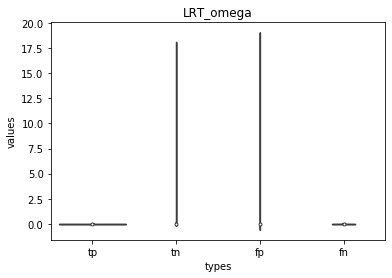

In [228]:
plt.rcParams['figure.figsize'] = [6,4]
overall(X_test, omit_gb[1],  omit_gb[0], 6, 'LRT_omega', 'figure/4_violin_plot_LRT_omega.pdf')

p values between correct and incorrect groups is 0.6691297957469389 

p values between tp and fp is 0.0005934769062153622 

p values between tn and fn is 0.005391159065641693 

p values between tp and tn is 0.9971045388729833 

p values between fp and fn is 0.5512867681710389 

p values between tp and fn is 1.2954575511869848e-05 

p values between tn and fp is 0.002919667502746859 



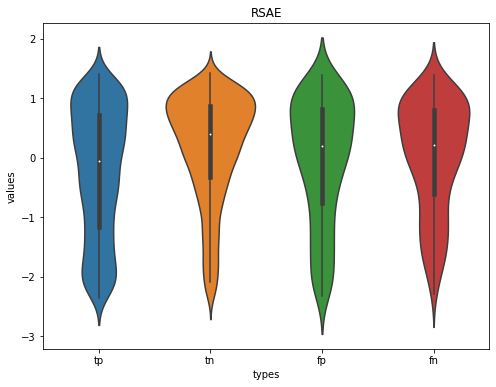

In [198]:
overall(X_test, omit_gb[1],  omit_gb[0], 14, 'RSAE', 'figure/4_violin_plot_RSAE.pdf')

p values between correct and incorrect groups is 0.505568367699267 

p values between tp and fp is 0.07899558485722524 

p values between tn and fn is 0.0008033807357502587 

p values between tp and tn is 0.9971045388729833 

p values between fp and fn is 0.6374595409843395 

p values between tp and fn is 0.007541247884305324 

p values between tn and fp is 0.0033584940638039518 



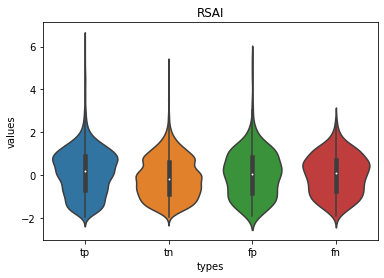

In [190]:
#predRSAI
overall(X_test, omit_gb[1],  omit_gb[0], 13, 'RSAI','figure/4_violin_plot_RSAi.pdf')

In [186]:
X_test.columns[12]

'PredRSAB'

In [ ]:
overall(X_test, omit_gb[1],  omit_gb[0], 22,'PredSSH')

p values between correct and incorrect groups is 0.6887277756886304 

p values between tp and fp is 0.0017300417968368897 

p values between tn and fn is 0.0011163483824820908 

p values between tp and tn is 0.9971045388729833 

p values between fp and fn is 0.8599784693359039 

p values between tp and fn is 0.0005112699363591933 

p values between tn and fp is 0.019154861038725213 



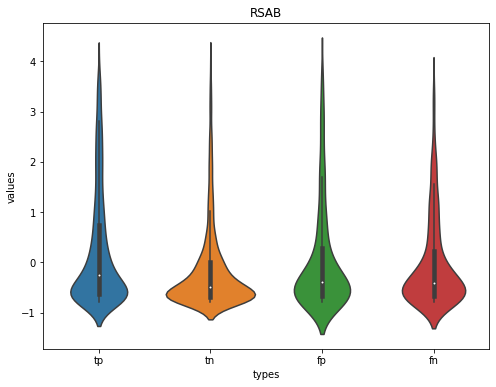

In [207]:
overall(X_test, omit_gb[1],  omit_gb[0], 12,'RSAB','figure/4_violin_plot_RSAB.pdf')

p values between correct and incorrect groups is 1.1863358227286131e-14 

p values between tp and fp is 1.2212453270876722e-15 

p values between tn and fn is 2.886579864025407e-15 

p values between tp and tn is 0.9971045388729833 

p values between fp and fn is 3.090181412588528e-40 

p values between tp and fn is 4.565894951961885e-143 

p values between tn and fp is 6.661338147750939e-16 



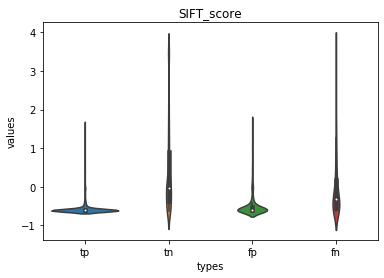

In [192]:
overall(X_test, omit_gb[1],  omit_gb[0], 5,'SIFT_score','figure/4_violin_plot_SIFT.pdf')

p values between correct and incorrect groups is 1.2528250307905468e-20 

p values between tp and fp is 1.2212453270876722e-15 

p values between tn and fn is 2.886579864025407e-15 

p values between tp and tn is 0.9971045388729833 

p values between fp and fn is 1.2391309579337417e-43 

p values between tp and fn is 7.947058941448659e-157 

p values between tn and fp is 6.661338147750939e-16 



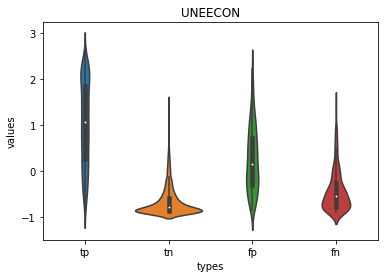

In [193]:
overall(X_test, omit_gb[1],  omit_gb[0], 29,'UNEECON','figure/4_violin_plot_UNEECON.pdf')

In [385]:
prediction_location(omit_gb[1], omit_gb[1])[1][0]
X_test.iloc[np.r_[tp_loc],5:13]

X_test.iloc[np.r_[tp_loc],10:16]



,HMMEntropy,HMMRelEntropy,PredRSAB,PredRSAI,PredRSAE,PredBFactorF
43143,0.788529,0.298194,-0.775546,-1.690883,1.293349,-0.157798
19243,-0.650601,-0.617531,-0.674150,-0.659716,0.783473,-1.217218
14143,2.429252,3.020835,0.770758,0.995578,-0.997289,-0.687507
77278,0.067200,-0.013331,1.906405,0.434769,-1.613708,3.550171
11412,2.153968,2.515976,2.671953,0.217681,-2.096950,1.961042
...,...,...,...,...,...,...
2185,-0.576357,-0.555176,-0.755267,-1.301934,1.114511,-0.157798
16974,-0.735891,-0.594525,-0.572752,-0.442628,0.612246,0.901621
74235,-0.067198,0.198683,1.303093,1.022715,-1.408236,-0.687507
9189,-0.555560,-0.481002,0.106607,0.326225,-0.217256,-0.687507


In [254]:
len(fn)  #434
len(fp)  #374

374

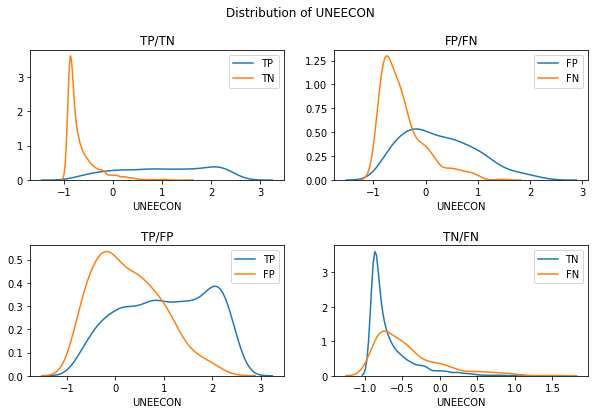

p values between correct and incorrect groups is 3.2781824369908932e-12
p values between tp and fp is 3.0361404227747827e-53
p values between tn and fn is 8.217147443312917e-38


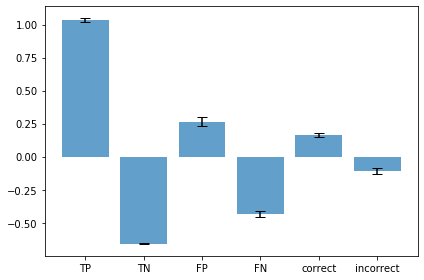

In [390]:
overall(X_test, omit_gb[1],  omit_gb[0], 29, 'UNEECON')

In [263]:
X_test.loc[:,'SIFT_score'].corr( X_test.loc[:, 'PredRSAE'], method = 'spearman')

0.12254576845371014